In [4159]:
import pandas as pd
import pandas_profiling

import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA

import pydot
from IPython.display import Image
import matplotlib.pyplot as plt

import time

import seaborn as sn

# In order to see full screen (horizontal scrolling) dataframes
from IPython.display import display
pd.options.display.max_columns = None

# === === === === === === === === === ===
# Ziel / Problembeschreibung

Für den gewählten Datensatz soll versucht werden mittels Regressionsmethoden die Gehälter der NBA-Spieler vorherzusagen. Welche Features sind ausschlaggebend für ein hohes bzw. niedriges Gehalt?

# === === === === === === === === === ===
# Daten

Die Datensätze __salaries__ und __players__ wurden aus folgender Quelle gewählt: https://data.world/datadavis/nba-salaries.

Der Datensatz __seasons_stats__ wurde aus folgender Quelle gewählt: https://www.kaggle.com/drgilermo/nba-players-stats

In [4160]:
salaries_df = pd.read_csv('data/salaries.csv')
players_df = pd.read_csv('data/players.csv')
seasons_stats_df = pd.read_csv('data/seasons_stats.csv')

# === === === === === === === === === ===
# Datenaufbereitung

## === === === === === === === === === ===
## Dataframe: Salaries

Diese Daten von https://data.world/datadavis/nba-salaries bilden den Ausgangspunkt für die beschriebene Fragestellung. Der Datensatz beinhaltet im Wesentlichen das ausbezahlte __Gehalt__ an einen Spieler für eine bestimmte __Saison__.

In [4161]:
salaries_df.sample()

league  player_id   salary   season  season_end  season_start  \
3418    NBA  douglsh01  1000000  1999-00        2000          1999   

                 team  
3418  New Jersey Nets

### Pandas Profiling Report

Der nachfolgende _Pandas Profiling Report_ verschafft einen vollständigen Überblick (Statistiken, Visualisierungen) über den importierten Datensatz. Die Datei _salaries_profile_report_ zeigt das Ergebnis des Reports.

In [4162]:
# salaries_profile_report = salaries_df.profile_report()
# salaries_profile_report.to_file(output_file="salaries_profile_report.html")

### Analyse der einzelnen Spalten

In [4163]:
salaries_df.columns

Index(['league', 'player_id', 'salary', 'season', 'season_end', 'season_start',
       'team'],
      dtype='object')

#### League

Laut dem _Pandas Profiling Report_ handelt es sich bei der Variable __league__ um eine Konstante. Alle Spieler des Datensatzes sind in der _NBA_ tätig. Das Feature schafft somit keinen Mehrwert und kann entfernt werden.

In [4164]:
salaries_df['league'].describe()

count     14163
unique        1
top         NBA
freq      14163
Name: league, dtype: object

In [4165]:
salaries_df.drop(columns=['league'], inplace=True)

#### Player ID

Die Variable __player_id__ kann zunächst im Datensatz gelassen werden. Über diese ID können später die zusätzlichen Daten des Spielers vom Datensatz __Players__ eingebunden werden.

#### Salary

Die wichtigste Variable __salary__ wird natürlich im Datensatz behalten.

#### Season (Start, End)

Die Variablen __season__, __season_start__ und __season_end__ müssen nicht alle im Datensatz belassen werden. Die Variable __season__ kann aus den beiden anderen konstruiert werden und ist somit redundant. Sie kann somit entfernt werden.

In [4166]:
salaries_df.drop(columns=['season'], inplace=True)

### Ergebnis

In [4167]:
salaries_df.head()

player_id  salary  season_end  season_start                    team
0  abdelal01  395000        1991          1990  Portland Trail Blazers
1  abdelal01  494000        1992          1991  Portland Trail Blazers
2  abdelal01  500000        1993          1992          Boston Celtics
3  abdelal01  805000        1994          1993          Boston Celtics
4  abdelal01  650000        1995          1994        Sacramento Kings

In [4168]:
salaries_df.tail()

player_id   salary  season_end  season_start                 team
14158  zipsepa01   750000        2017          2016        Chicago Bulls
14159  zipsepa01  1312611        2018          2017        Chicago Bulls
14160  zizican01  1645200        2018          2017  Cleveland Cavaliers
14161  zubaciv01  1034956        2017          2016   Los Angeles Lakers
14162  zubaciv01  1312611        2018          2017   Los Angeles Lakers

In [4169]:
salaries_df.sample(7)

player_id   salary  season_end  season_start                 team
2402   childch01  1750000        2003          2002      New Jersey Nets
7514   lewisra02  8571429        2006          2005  Seattle SuperSonics
7622    longjo01   330000        1985          1984      Detroit Pistons
7723   lydonty01  1579440        2018          2017       Denver Nuggets
13692  willije01  7014400        2007          2006      New York Knicks
5313   harride01  7800000        2009          2008      New Jersey Nets
363    anderni01   800000        1993          1992        Orlando Magic

In [4170]:
salaries_df.describe()

salary   season_end  season_start
count  1.416300e+04  14163.00000   14163.00000
mean   3.164870e+06   2003.66942    2002.66942
std    4.185046e+06      9.16469       9.16469
min    2.706000e+03   1985.00000    1984.00000
25%    6.300000e+05   1996.00000    1995.00000
50%    1.500000e+06   2004.00000    2003.00000
75%    3.884239e+06   2012.00000    2011.00000
max    3.468255e+07   2018.00000    2017.00000

In [4171]:
salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14163 entries, 0 to 14162
Data columns (total 5 columns):
player_id       14163 non-null object
salary          14163 non-null int64
season_end      14163 non-null int64
season_start    14163 non-null int64
team            14159 non-null object
dtypes: int64(3), object(2)
memory usage: 553.4+ KB


## === === === === === === === === === ===
## Dataframe: Players

Die Daten von https://data.world/datadavis/nba-salaries komplementieren den zuvor beschriebenen __Salaries__ Datensatz. Sie beinhalten im Wesentlichen __Informationen zu den jeweiligen Spielern__.

In [4172]:
players_df.sample()

_id     birthDate       birthPlace  career_AST career_FG%  \
4149  tisdawa01  June 9, 1964  Tulsa, Oklahoma         1.3       50.5   

     career_FG3% career_FT%  career_G career_PER  career_PTS career_TRB  \
4149         0.0       76.0       840       15.7        15.3        6.1   

     career_WS career_eFG%                 college   draft_pick draft_round  \
4149      45.7        50.5  University of Oklahoma  2nd overall   1st round   

          draft_team draft_year height  \
4149  Indiana Pacers       1985    6-9   

                                   highSchool            name       position  \
4149  Booker T. Washington in Tulsa, Oklahoma  Wayman Tisdale  Power Forward   

     shoots weight  
4149   Left  240lb

### Pandas Profiling Report

Der nachfolgende _Pandas Profiling Report_ verschafft einen vollständigen Überblick (Statistiken, Visualisierungen) über den importierten Datensatz. Die Datei _players_profile_report_ zeigt das Ergbnis des Reports.

In [4173]:
# players_profile_report = players_df.profile_report()
# players_profile_report.to_file(output_file="players_profile_report.html")

### Analyse der einzelnen Spalten

In [4174]:
players_df.columns

Index(['_id', 'birthDate', 'birthPlace', 'career_AST', 'career_FG%',
       'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS',
       'career_TRB', 'career_WS', 'career_eFG%', 'college', 'draft_pick',
       'draft_round', 'draft_team', 'draft_year', 'height', 'highSchool',
       'name', 'position', 'shoots', 'weight'],
      dtype='object')

#### ID

Die Variable __id__ kann zunächst im Datensatz belassen werden. Mit dieser Variable kann nämlich später das Matching mit dem __Salaries__ Datensatz vollzogen werden.

#### Birth Date

Laut dem _Pandas Profiling Report_ weißt die Variable __birthDate__ folgende Probleme auf:

- Hohe Kardinalität
- Uniform

Außerdem hat die Variable __28__ fehlende Datenpunkte.

Prinzipiell könnten die Features _birth_month_, _birth_day_ und _birth_year_ aus der genannten Variable entnommen werden. Dies scheint auf den ersten Blick jedoch keinen wirklichen Mehrwert zu bieten. Somit wird dieses Feature verworfen.

In [4175]:
players_df.drop(columns=['birthDate'], inplace=True)

#### Birth Place

Laut dem _Pandas Profiling Report_ weißt die Variable __birthPlace__ folgende Probleme auf:

- Fehlende Datenpunkte || 10.7%
- Hohe Kardinalität || 39%


##### Fehlende Datenpunkte

Die fehlenden Daten werden mit dem Top-Wert aufgefüllt.

In [4176]:
players_df['birthPlace'].describe()

count                  4185
unique                 1632
top       Chicago, Illinois
freq                    137
Name: birthPlace, dtype: object

In [4177]:
players_df['birthPlace'] = players_df['birthPlace'].fillna("Chicago, Illinois")

##### Hohe Kardinalität

Um dieses Problem zu lösen soll nur das Land in Betracht gezogen werden. Eine drastischere Maßnahme wäre die reine Verwendung des Features __born_in_usa__. Diese Variable wurde nur Aufschluss darüber geben, ob der Spieler in der USA geboren wurde oder nicht.

In [4178]:
players_df['birthPlace'].describe()

count                  4685
unique                 1632
top       Chicago, Illinois
freq                    637
Name: birthPlace, dtype: object

Wie man oberhalb erkennen kann weißt das Feature 1632 einmalige Werte auf.

In [4179]:
def generalizeBirthPlace(birthPlace):
    splitted =  birthPlace.split(",")
    
    return splitted[1] if len(splitted) >= 2 else ",".join(splitted)

In [4180]:
def statesToUSA(birthPlace):
    states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
              "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
              "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
              "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]
    
    def process(string):
        return string.lower().strip()
        
    states = map(process, states)
    
    return "USA" if process(birthPlace) in states else birthPlace

In [4181]:
players_df['birthPlace'] = players_df['birthPlace'].apply(generalizeBirthPlace)

In [4182]:
players_df['birthPlace'] = players_df['birthPlace'].apply(statesToUSA)

In [4183]:
players_df.rename(columns={"birthPlace": "birth_country"}, inplace=True)

In [4184]:
players_df['birth_country'].sample(7)

4552         USA
2993     Senegal
2304         USA
4617         USA
351          USA
3335         USA
3882         USA
Name: birth_country, dtype: object

In [4185]:
players_df['birth_country'].describe()

count     4685
unique      90
top        USA
freq      4160
Name: birth_country, dtype: object

Durch die reine Verwendung des Landes lassen sich 1632 einmalige Werte auf 90 reduzieren.

In [4186]:
players_df['born_in_usa'] = np.where(players_df['birth_country'] == 'USA', True, False)

In [4187]:
players_df['born_in_usa'].describe()

count     4685
unique       2
top       True
freq      4160
Name: born_in_usa, dtype: object

#### Career Stats

Alle Variablen die Statistiken zu der gesamten Karriere des Spielers beinhalten können verworfen werden. Diese Features würden keinen Mehrwert für das aktuelle Gehalt in dieser Saison bieten. Stattdessen sollen im weiteren Verlauf die jeweiligen Saisonstatistiken des Spielers durch einen weiteren Datensatz erweitert werden.

In [4188]:
players_df.drop(columns=['career_AST', 'career_FG%', 'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS', 'career_TRB', 'career_WS', 'career_eFG%'], inplace=True)

#### College

Laut dem _Pandas Profiling Report_ weißt die Variable __college__ folgende Probleme auf:

- Fehlende Datenpunkte || 6.7%
- Hohe Kardinalität || 16.7%

##### Fehlende Datenpunkte

Das Problem der fehlenden Datenpunkte wird durch folgende Annahme behoben: Fehlende Datenpunkte repräsentieren Spieler, die kein College besucht haben. _LeBron James_ hat beispielsweise kein College eingetragen und auch tatsächlich kein College besucht. Deshalb wird der Wert _NO_COLLEGE_ bei diesen Spielern hinzugefügt.

In [4189]:
players_df['college'] = players_df['college'].fillna('NO_COLLEGE')

In [4190]:
players_df['college'].describe()

count           4685
unique           732
top       NO_COLLEGE
freq             313
Name: college, dtype: object

##### Hohe Kardinalität

Das Problem der hohen Kardinalität scheint derzeit nicht lösbar zu sein. Eine drastische Maßnahme wäre ausschließlich das Feature __attended_college__ aufzunehmen.

In [4191]:
players_df['attended_college'] = np.where(players_df['college'] == 'NO_COLLEGE', False, True)

In [4192]:
players_df['attended_college'].describe()

count     4685
unique       2
top       True
freq      4372
Name: attended_college, dtype: object

#### Draft

Laut dem _Pandas Profiling Report_ weißen die Features __draft_pick__, __draft_round__, __draft_team__, __draft_year__ folgende Probleme auf:

- Hohe Kardinalität
- Fehlende Datenpunkte

Diese Probleme sollen durch die Extrahierung eines neuen Features __drafted_player__ behoben werden. Die ursprünglichen Features werden verworfen. Das neue Feature beruht auf der Annahme, dass es sich bei diesen Spielern um _undrafted players_ handelt. Da es diese Kategorie im Datensatz nicht gibt und diese Art von Spielern jedoch sehrwohl existieren wird in dieser Analyse von diesem Umstand ausgegangen.

In [4193]:
players_df['drafted_player'] = np.where(
    players_df['draft_pick'].isna() |
    players_df['draft_round'].isna() |
    players_df['draft_team'].isna() |
    players_df['draft_year'].isna(), True, False
)

In [4194]:
players_df['drafted_player'].describe()

count      4685
unique        2
top       False
freq       3306
Name: drafted_player, dtype: object

Die originalen Features werden nicht benötigt und können vom Datensatz entfernt werden.

In [4195]:
players_df.drop(columns=['draft_pick', 'draft_round', 'draft_team', 'draft_year'], inplace=True)

#### Height

Bei der Variable __height__ handelt es sich derzeit um kategorische Daten. Die Größe soll daher in eine numerische Repräsentation umgewandelt werden. Im originalen Datensatz handelt es sich um eine Foot-Inch Darstellung. Daher wird die Größe auf Inches umgerechnet.

In [4196]:
def heightToInches(height):
    foot_and_inches = height.split('-')
    foot_in_inches = int(foot_and_inches[0]) * 12
    inches = int(foot_and_inches[1])
    
    return foot_in_inches + inches

In [4197]:
players_df['height'].describe()

count     4685
unique      28
top        6-7
freq       486
Name: height, dtype: object

In [4198]:
players_df['height'] = players_df['height'].apply(heightToInches)

In [4199]:
players_df.rename(columns={"height": "height_in_inches"}, inplace=True)

In [4200]:
players_df['height_in_inches'].sample(7)

1352    78
1822    80
3911    68
153     82
4108    80
943     83
682     81
Name: height_in_inches, dtype: int64

#### High School

Die Variable __highSchool__ weißt Ähnlichkeiten mit dem Feature __college__ auf: 

- Hohe Kardinalität || 67.3%
- Fehlende Datenpunkte || 14.1%

Da dieses Feature eine wirkliche hohe Kardinalität besitzt soll ausschließlich das Feature __attended_high_school__ extrahiert werden.

In [4201]:
players_df['highSchool'].describe()

count                                              4025
unique                                             2708
top       Oak Hill Academy in Mouth of Wilson, Virginia
freq                                                 29
Name: highSchool, dtype: object

In [4202]:
players_df['highSchool'] = players_df['highSchool'].isna()

In [4203]:
players_df.rename(columns={"highSchool": "attended_high_school"}, inplace=True)

In [4204]:
players_df['attended_high_school'].sample(7)

2995     True
3110     True
2019    False
3309    False
1481     True
470      True
432     False
Name: attended_high_school, dtype: bool

#### Name

Laut dem _Pandas Profiling Report_ weißt die Variable __name__ folgende Probleme auf:

- Hohe Kardinalität || 99%
- Uniform 

Möglicherweise könnte man __name_length__ aus dem genannten Feature extrahieren, jedoch besteht die Vermutung, dass der Name keinen großen Einfluss auf das Gehalt der Spieler hat. Deshalb soll das Feature aus dem Datensatz entfernt werden. Vorerst wird es jedoch beibehalten, da es später für ein Matching mit einem anderen Datensatz verwendet wird.

#### Position

Laut dem _Pandas Profiling Report_ weißt die Variable _position_ keine hohe Kardinalität auf. Dennoch wird versucht die möglichen Ausprägungen etwas einzuschränken. Spieler denen mehrer Positionen zugeordnet sind bekommen einen dementsprechenden Eintrag. Eine drastischere Vorgehensweise wäre die reine Verwendung des Features __multiple_positions__.

In [4205]:
def processMultiplePositions(position):
    return "MULTIPLE_POSITIONS" if "and" in position.split() else position

In [4206]:
players_df['position'].describe()

count               4685
unique                43
top       Shooting Guard
freq                 679
Name: position, dtype: object

In [4207]:
players_df['position'] = players_df['position'].apply(processMultiplePositions)

In [4208]:
players_df['position'].describe()

count                   4685
unique                    12
top       MULTIPLE_POSITIONS
freq                    1208
Name: position, dtype: object

In [4209]:
players_df['position'].sample(7)

3657    Power Forward
1279           Center
2942    Power Forward
2479    Small Forward
3263    Guard/Forward
1972    Small Forward
1996      Point Guard
Name: position, dtype: object

In [4210]:
players_df['multiple_positions'] = np.where(players_df['position'] == "MULTIPLE_POSITIONS", True, False)

In [4211]:
players_df['multiple_positions'].describe()

count      4685
unique        2
top       False
freq       3477
Name: multiple_positions, dtype: object

#### Shoots

Die Variable __shoots__ kann vorerst ohne weitere Bearbeitung übernommen werden.

#### Weight

Laut dem _Pandas Profiling Report_ weißt die Variable __weight__ folgendes Problem auf:

- Hohe Kardinalität || 3.1%

Derzeit handelt es sich beim Gewicht um einen kategorischen Wert. Das Gewicht soll daher in eine numerische Repräsentation umgewandelt werden. Somit wird die Einheit wird entfernt und der Datentyp angepasst.

##### Fehlende Datenpunkte

Laut dem _Pandas Profiling Report_ hat diese Variable __5__ fehlende Datenpunkte. Diese werden durch den Top-Wert aufgefüllt.

In [4212]:
players_df['weight'].describe()

count      4680
unique      143
top       210lb
freq        334
Name: weight, dtype: object

In [4213]:
players_df['weight'] = players_df['weight'].fillna('210lb')

##### Wertumwandlung

In [4214]:
players_df['weight'].describe()

count      4685
unique      143
top       210lb
freq        339
Name: weight, dtype: object

In [4215]:
def removeLB(weight):
    return weight[:-2]

In [4216]:
players_df['weight'] = players_df['weight'].apply(removeLB)

In [4217]:
players_df['weight'] = players_df['weight'].astype(int)

In [4218]:
players_df['weight'].sample(7)

3244    185
11      183
2326    190
2619    225
2194    228
1724    215
4369    160
Name: weight, dtype: int64

### Ergebnis

In [4219]:
players_df.head()

_id birth_country                                            college  \
0  abdelal01         Egypt                                    Duke University   
1  abdulza01           USA                              Iowa State University   
2  abdulka01           USA              University of California, Los Angeles   
3  abdulma02           USA                         Louisiana State University   
4  abdulta01        France  University of Michigan, San Jose State University   

   height_in_inches  attended_high_school                 name  \
0                82                 False       Alaa Abdelnaby   
1                81                 False      Zaid Abdul-Aziz   
2                86                 False  Kareem Abdul-Jabbar   
3                73                 False   Mahmoud Abdul-Rauf   
4                78                 False    Tariq Abdul-Wahad   

             position shoots  weight  born_in_usa  attended_college  \
0       Power Forward  Right     240        False              True   
1  MULTIPLE_POSITIONS  Right     235         True              True   
2              Center  Right     225         True              True   
3         Point Guard  Right     162         True              True   
4      Shooting Guard  Right     223        False              True   

   drafted_player  multiple_positions  
0           False               False  
1           False                True  
2           False               False  
3           False               False  
4           False               False

In [4220]:
players_df.tail()

_id            birth_country                       college  \
4680  zizican01                  Croatia                    NO_COLLEGE   
4681   zoetji01                   Canada         Kent State University   
4682   zopfbi01                      USA           Duquesne University   
4683  zubaciv01   Bosnia and Herzegovina                    NO_COLLEGE   
4684  zunicma01                      USA  George Washington University   

      height_in_inches  attended_high_school         name       position  \
4680                83                  True   Ante Zizic         Center   
4681                85                 False     Jim Zoet         Center   
4682                73                 False    Bill Zopf    Point Guard   
4683                85                  True  Ivica Zubac         Center   
4684                75                  True   Matt Zunic  Guard/Forward   

     shoots  weight  born_in_usa  attended_college  drafted_player  \
4680  Right     254        False             False           False   
4681  Right     240        False              True            True   
4682  Right     170         True              True           False   
4683  Right     240        False             False           False   
4684  Right     195         True              True            True   

      multiple_positions  
4680               False  
4681               False  
4682               False  
4683               False  
4684               False

In [4221]:
players_df.sample(7)

_id birth_country  \
2442    leeku01           USA   
4385   webbsp01           USA   
4277  volkoal01        Russia   
3870  smithjo03           USA   
3     abdulma02           USA   
1384  gainebi01           USA   
3384  quinnbr01           USA   

                                               college  height_in_inches  \
2442    Western Kentucky University, Towson University                75   
4385  Midland College, North Carolina State University                66   
4277                                        NO_COLLEGE                82   
3870                                        NO_COLLEGE                81   
3                           Louisiana State University                73   
1384                       East Texas State University                76   
3384                       Washington State University                80   

      attended_high_school                name            position shoots  \
2442                 False            Kurk Lee         Point Guard  Right   
4385                 False           Spud Webb         Point Guard  Right   
4277                  True    Alexander Volkov              Center  Right   
3870                 False          Josh Smith  MULTIPLE_POSITIONS   Left   
3                    False  Mahmoud Abdul-Rauf         Point Guard  Right   
1384                  True         Bill Gaines               Guard  Right   
3384                 False      Brian Quinnett      Shooting Guard  Right   

      weight  born_in_usa  attended_college  drafted_player  \
2442     190         True              True            True   
4385     133         True              True           False   
4277     218        False             False           False   
3870     225         True             False           False   
3        162         True              True           False   
1384     185         True              True           False   
3384     235         True              True           False   

      multiple_positions  
2442               False  
4385               False  
4277               False  
3870                True  
3                  False  
1384               False  
3384               False

In [4222]:
players_df.describe()

height_in_inches       weight
count       4685.000000  4685.000000
mean          78.032657   209.056564
std            3.632334    26.125355
min           63.000000   114.000000
25%           75.000000   190.000000
50%           78.000000   210.000000
75%           81.000000   225.000000
max           91.000000   360.000000

In [4223]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4685 entries, 0 to 4684
Data columns (total 13 columns):
_id                     4685 non-null object
birth_country           4685 non-null object
college                 4685 non-null object
height_in_inches        4685 non-null int64
attended_high_school    4685 non-null bool
name                    4685 non-null object
position                4685 non-null object
shoots                  4684 non-null object
weight                  4685 non-null int64
born_in_usa             4685 non-null bool
attended_college        4685 non-null bool
drafted_player          4685 non-null bool
multiple_positions      4685 non-null bool
dtypes: bool(5), int64(2), object(6)
memory usage: 315.8+ KB


## === === === === === === === === === ===
## Dataframe: Seasons Stats

Die Daten von https://www.kaggle.com/drgilermo/nba-players-stats sollen als Erweiterung des __Salaries__ Datensatz fungieren. Wie bereits erwähnt, sind die _Career Stats_ des __Players__ Datensatzes eher unbrauchbar. Es macht vermutlich mehr Sinn, dass jeweilige Gehalt in einer Saison durch die entsprechenden _seasons_stats_ zu erweitern. Dies soll durch diesen Datensatz ermöglicht werden. Er beinhaltet im Wesentlichen __Statistiken von einem Spieler in einer Saison__.

In [4224]:
seasons_stats_df.sample()

Unnamed: 0    Year         Player Pos   Age   Tm     G   GS     MP  \
10104       10104  1991.0  Byron Dinkins  PG  23.0  SAS  10.0  0.0  144.0   

       PER   TS%  3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  \
10104  4.5  0.46   0.0  0.273   0.0   8.0   4.2  17.2   0.7   0.0  26.0  14.5   

       blanl  OWS  DWS   WS  WS/48  blank2  OBPM  DBPM  BPM  VORP    FG   FGA  \
10104    NaN -0.2  0.1  0.0 -0.017     NaN  -6.4  -1.5 -8.0  -0.2  13.0  33.0   

         FG%   3P  3PA  3P%    2P   2PA    2P%   eFG%   FT  FTA    FT%  ORB  \
10104  0.394  0.0  0.0  NaN  13.0  33.0  0.394  0.394  8.0  9.0  0.889  0.0   

        DRB   TRB   AST  STL  BLK   TOV    PF   PTS  
10104  11.0  11.0  19.0  2.0  0.0  13.0  12.0  34.0

### Analyse der einzelnen Spalten

In [4225]:
seasons_stats_df.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

#### Unnamed

Die erste Variable __unnamed__ scheint einen Index darzustellen. Sie kann ohne weitere Bedenken entfernt werden.

In [4226]:
seasons_stats_df.drop(seasons_stats_df.columns[0], axis=1, inplace=True)

#### Year und Player

Die Variablen __year__ und __player__ sollen für das Matching mit den anderen Datensätzen verwendet werden. Die Variable __year__ kann mit __season_end__ des __Salaries__ Datensatzes verbunden werden.

#### Position

Dieser Datensatz beinhaltet ebenfalls eine Variable __Pos__ (Position). Diese kennzeichnet jedoch die Position in dieser Saison. Daher wird dieses feature und nicht das Feature des anderen Datensatzes verwendet. Die erstellten Features des anderen Datensatzes können somit zunächst verworfen werden.

In [4227]:
seasons_stats_df['Pos'].describe()

count     24624
unique       23
top          PF
freq       4966
Name: Pos, dtype: object

In [4228]:
players_df.drop(columns=['position', 'multiple_positions'], inplace=True)

#### Age

Das Alter des jeweiligen Spielers scheint auf jeden Fall Sinn zu machen. Daher wird dieses Feature behalten.

In [4229]:
seasons_stats_df['Age'].describe()

count    24616.000000
mean        26.664405
std          3.841892
min         18.000000
25%         24.000000
50%         26.000000
75%         29.000000
max         44.000000
Name: Age, dtype: float64

#### Saisonstatistiken

Alle Saisonstatistiken des Spielers sollen natürlich behalten werden. Der Datensatz soll genau diese Erweiterung an Daten liefern.

### Ergebnis

In [4230]:
seasons_stats_df.head()

Year           Player  Pos   Age   Tm     G  GS  MP  PER    TS%  3PAr  \
0  1950.0  Curly Armstrong  G-F  31.0  FTW  63.0 NaN NaN  NaN  0.368   NaN   
1  1950.0     Cliff Barker   SG  29.0  INO  49.0 NaN NaN  NaN  0.435   NaN   
2  1950.0    Leo Barnhorst   SF  25.0  CHS  67.0 NaN NaN  NaN  0.394   NaN   
3  1950.0       Ed Bartels    F  24.0  TOT  15.0 NaN NaN  NaN  0.312   NaN   
4  1950.0       Ed Bartels    F  24.0  DNN  13.0 NaN NaN  NaN  0.308   NaN   

     FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  blanl  OWS  DWS  \
0  0.467   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN -0.1  3.6   
1  0.387   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  1.6  0.6   
2  0.259   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  0.9  2.8   
3  0.395   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN -0.5 -0.1   
4  0.378   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN -0.5 -0.1   

    WS  WS/48  blank2  OBPM  DBPM  BPM  VORP     FG    FGA    FG%  3P  3PA  \
0  3.5    NaN     NaN   NaN   NaN  NaN   NaN  144.0  516.0  0.279 NaN  NaN   
1  2.2    NaN     NaN   NaN   NaN  NaN   NaN  102.0  274.0  0.372 NaN  NaN   
2  3.6    NaN     NaN   NaN   NaN  NaN   NaN  174.0  499.0  0.349 NaN  NaN   
3 -0.6    NaN     NaN   NaN   NaN  NaN   NaN   22.0   86.0  0.256 NaN  NaN   
4 -0.6    NaN     NaN   NaN   NaN  NaN   NaN   21.0   82.0  0.256 NaN  NaN   

   3P%     2P    2PA    2P%   eFG%     FT    FTA    FT%  ORB  DRB  TRB    AST  \
0  NaN  144.0  516.0  0.279  0.279  170.0  241.0  0.705  NaN  NaN  NaN  176.0   
1  NaN  102.0  274.0  0.372  0.372   75.0  106.0  0.708  NaN  NaN  NaN  109.0   
2  NaN  174.0  499.0  0.349  0.349   90.0  129.0  0.698  NaN  NaN  NaN  140.0   
3  NaN   22.0   86.0  0.256  0.256   19.0   34.0  0.559  NaN  NaN  NaN   20.0   
4  NaN   21.0   82.0  0.256  0.256   17.0   31.0  0.548  NaN  NaN  NaN   20.0   

   STL  BLK  TOV     PF    PTS  
0  NaN  NaN  NaN  217.0  458.0  
1  NaN  NaN  NaN   99.0  279.0  
2  NaN  NaN  NaN  192.0  438.0  
3  NaN  NaN  NaN   29.0   63.0  
4  NaN  NaN  NaN   27.0   59.0

In [4231]:
seasons_stats_df.tail()

Year             Player Pos   Age   Tm     G    GS      MP   PER  \
24686  2017.0        Cody Zeller  PF  24.0  CHO  62.0  58.0  1725.0  16.7   
24687  2017.0       Tyler Zeller   C  27.0  BOS  51.0   5.0   525.0  13.0   
24688  2017.0  Stephen Zimmerman   C  20.0  ORL  19.0   0.0   108.0   7.3   
24689  2017.0        Paul Zipser  SF  22.0  CHI  44.0  18.0   843.0   6.9   
24690  2017.0        Ivica Zubac   C  19.0  LAL  38.0  11.0   609.0  17.0   

         TS%   3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  \
24686  0.604  0.002  0.442   8.6  17.3  12.9   9.1   1.8   3.0  10.9  15.5   
24687  0.508  0.006  0.247   9.2  17.0  13.2  12.2   0.7   3.3  10.2  16.5   
24688  0.346  0.000  0.161  10.8  24.9  17.6   5.3   0.9   3.7   8.3  14.8   
24689  0.503  0.448  0.181   1.9  14.2   8.0   6.1   0.9   1.5  14.4  14.4   
24690  0.547  0.013  0.206   7.1  21.9  14.3   8.1   1.1   4.4  10.4  20.3   

       blanl  OWS  DWS   WS  WS/48  blank2  OBPM  DBPM  BPM  VORP     FG  \
24686    NaN  3.4  2.2  5.6  0.157     NaN  -0.2   2.3  2.1   1.8  253.0   
24687    NaN  0.5  0.6  1.0  0.094     NaN  -3.2   0.8 -2.5  -0.1   78.0   
24688    NaN -0.1  0.1  0.0 -0.005     NaN  -7.8   0.4 -7.3  -0.1   10.0   
24689    NaN -0.3  0.8  0.5  0.030     NaN  -3.6  -0.1 -3.7  -0.4   88.0   
24690    NaN  0.6  0.5  1.1  0.086     NaN  -2.7   0.3 -2.5  -0.1  126.0   

         FGA    FG%    3P   3PA    3P%     2P    2PA    2P%   eFG%     FT  \
24686  443.0  0.571   0.0   1.0  0.000  253.0  442.0  0.572  0.571  133.0   
24687  158.0  0.494   0.0   1.0  0.000   78.0  157.0  0.497  0.494   22.0   
24688   31.0  0.323   0.0   0.0    NaN   10.0   31.0  0.323  0.323    3.0   
24689  221.0  0.398  33.0  99.0  0.333   55.0  122.0  0.451  0.473   31.0   
24690  238.0  0.529   0.0   3.0  0.000  126.0  235.0  0.536  0.529   32.0   

         FTA    FT%    ORB    DRB    TRB   AST   STL   BLK   TOV     PF    PTS  
24686  196.0  0.679  135.0  270.0  405.0  99.0  62.0  58.0  65.0  189.0  639.0  
24687   39.0  0.564   43.0   81.0  124.0  42.0   7.0  21.0  20.0   61.0  178.0  
24688    5.0  0.600   11.0   24.0   35.0   4.0   2.0   5.0   3.0   17.0   23.0  
24689   40.0  0.775   15.0  110.0  125.0  36.0  15.0  16.0  40.0   78.0  240.0  
24690   49.0  0.653   41.0  118.0  159.0  30.0  14.0  33.0  30.0   66.0  284.0

In [4232]:
seasons_stats_df.sample(7)

Year           Player Pos   Age   Tm     G    GS      MP   PER  \
6885   1983.0     Wayne Cooper   C  26.0  POR  80.0  60.0  2099.0  12.4   
12606  1996.0     Sam Mitchell  SF  32.0  MIN  78.0  42.0  2145.0  13.0   
5066   1978.0       Kenny Carr  PF  22.0  LAL  52.0   NaN   733.0   9.2   
21983  2013.0      Carl Landry  PF  29.0  GSW  81.0   2.0  1876.0  17.5   
2733   1969.0  Dennis Hamilton  PF  24.0  ATL  25.0   NaN   141.0  16.1   
5682   1979.0     Brian Taylor  PG  27.0  SDC  20.0   NaN   212.0  11.1   
23781  2016.0     LeBron James  SF  31.0  CLE  76.0  76.0  2709.0  27.5   

         TS%   3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  \
6885   0.479  0.007  0.272  11.4  21.3  16.3   7.6   0.6   3.6  16.7  18.8   
12606  0.566  0.029  0.471   6.0  12.9   9.5   5.7   1.2   0.9  10.4  17.2   
5066   0.476    NaN  0.281   7.7  20.9  14.5   4.7   1.1   1.0  20.8  22.8   
21983  0.605  0.005  0.453  10.9  17.3  14.2   5.6   0.9   1.3  13.7  20.0   
2733   0.549    NaN  0.075   NaN   NaN   NaN   8.7   NaN   NaN   NaN   NaN   
5682   0.418    NaN  0.217   6.5   6.5   6.5  11.8   5.1   0.0  15.8  19.3   
23781  0.588  0.199  0.347   4.7  18.8  11.8  36.0   2.0   1.5  13.2  31.4   

       blanl  OWS  DWS    WS  WS/48  blank2  OBPM  DBPM  BPM  VORP     FG  \
6885     NaN  0.1  2.8   2.9  0.067     NaN  -2.4   1.2 -1.2   0.4  320.0   
12606    NaN  3.1  1.1   4.3  0.095     NaN  -0.9  -1.3 -2.2  -0.1  303.0   
5066     NaN -0.9  0.9   0.0 -0.001     NaN  -5.2  -1.9 -7.0  -0.9  134.0   
21983    NaN  4.3  1.9   6.2  0.159     NaN   0.0  -0.7 -0.7   0.6  325.0   
2733     NaN  0.4  0.1   0.5  0.163     NaN   NaN   NaN  NaN   NaN   37.0   
5682     NaN -0.1  0.2   0.1  0.032     NaN  -1.9   0.5 -1.5   0.0   30.0   
23781    NaN  9.6  4.0  13.6  0.242     NaN   6.9   2.3  9.1   7.6  737.0   

          FGA    FG%    3P    3PA    3P%     2P     2PA    2P%   eFG%     FT  \
6885    723.0  0.443   0.0    5.0  0.000  320.0   718.0  0.446  0.443  135.0   
12606   618.0  0.490   1.0   18.0  0.056  302.0   600.0  0.503  0.491  237.0   
5066    302.0  0.444   NaN    NaN    NaN  134.0   302.0  0.444  0.444   55.0   
21983   602.0  0.540   1.0    3.0  0.333  324.0   599.0  0.541  0.541  223.0   
2733     67.0  0.552   NaN    NaN    NaN   37.0    67.0  0.552  0.552    2.0   
5682     83.0  0.361   NaN    NaN    NaN   30.0    83.0  0.361  0.361   16.0   
23781  1416.0  0.520  87.0  282.0  0.309  650.0  1134.0  0.573  0.551  359.0   

         FTA    FT%    ORB    DRB    TRB    AST    STL    BLK    TOV     PF  \
6885   197.0  0.685  214.0  397.0  611.0  116.0   27.0  136.0  162.0  318.0   
12606  291.0  0.814  107.0  232.0  339.0   74.0   49.0   26.0   87.0  220.0   
5066    85.0  0.647   53.0  155.0  208.0   26.0   18.0   14.0   89.0  127.0   
21983  273.0  0.817  180.0  303.0  483.0   65.0   35.0   31.0  115.0  190.0   
2733     5.0  0.400    NaN    NaN   29.0    8.0    NaN    NaN    NaN   19.0   
5682    18.0  0.889   13.0   13.0   26.0   20.0   24.0    0.0   17.0   34.0   
23781  491.0  0.731  111.0  454.0  565.0  514.0  104.0   49.0  249.0  143.0   

          PTS  
6885    775.0  
12606   844.0  
5066    323.0  
21983   874.0  
2733     76.0  
5682     76.0  
23781  1920.0

In [4233]:
seasons_stats_df.describe()

Year           Age             G            GS            MP  \
count  24624.000000  24616.000000  24624.000000  18233.000000  24138.000000   
mean    1992.594989     26.664405     50.837110     23.593375   1209.720317   
std       17.429594      3.841892     26.496161     28.632387    941.146575   
min     1950.000000     18.000000      1.000000      0.000000      0.000000   
25%     1981.000000     24.000000     27.000000      0.000000    340.000000   
50%     1996.000000     26.000000     58.000000      8.000000   1053.000000   
75%     2007.000000     29.000000     75.000000     45.000000   1971.000000   
max     2017.000000     44.000000     88.000000     83.000000   3882.000000   

                PER           TS%          3PAr           FTr          ORB%  \
count  24101.000000  24538.000000  18839.000000  24525.000000  20792.000000   
mean      12.479071      0.493001      0.158604      0.325455      6.181565   
std        6.039014      0.094469      0.187495      0.218971      4.872685   
min      -90.600000      0.000000      0.000000      0.000000      0.000000   
25%        9.800000      0.458000      0.005000      0.208000      2.600000   
50%       12.700000      0.506000      0.064000      0.296000      5.400000   
75%       15.600000      0.544000      0.288000      0.400000      9.000000   
max      129.100000      1.136000      1.000000      6.000000    100.000000   

               DRB%          TRB%          AST%          STL%          BLK%  \
count  20792.000000  21571.000000  22555.000000  20792.000000  20792.000000   
mean      13.708657      9.949210     13.009962      1.648269      1.410624   
std        6.636402      5.040283      9.191843      1.017024      1.773348   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        8.800000      5.900000      6.500000      1.100000      0.300000   
50%       12.700000      9.200000     10.500000      1.500000      0.900000   
75%       18.100000     13.500000     17.600000      2.100000      1.900000   
max      100.000000    100.000000    100.000000     24.200000     77.800000   

               TOV%          USG%  blanl           OWS           DWS  \
count  19582.000000  19640.000000    0.0  24585.000000  24585.000000   
mean      15.085099     18.906492    NaN      1.257307      1.227395   
std        6.919170      5.448157    NaN      2.136256      1.269613   
min        0.000000      0.000000    NaN     -5.100000     -1.000000   
25%       11.400000     15.400000    NaN     -0.100000      0.200000   
50%       14.200000     18.600000    NaN      0.400000      0.800000   
75%       17.700000     22.200000    NaN      1.900000      1.800000   
max      100.000000    100.000000    NaN     18.300000     16.000000   

                 WS         WS/48  blank2          OBPM          DBPM  \
count  24585.000000  24101.000000     0.0  20797.000000  20797.000000   
mean       2.485796      0.065002     NaN     -1.778386     -0.548570   
std        3.058638      0.102471     NaN      3.792947      2.253106   
min       -2.800000     -2.519000     NaN    -73.800000    -30.400000   
25%        0.200000      0.031000     NaN     -3.400000     -1.700000   
50%        1.400000      0.075000     NaN     -1.500000     -0.500000   
75%        3.800000      0.115000     NaN      0.300000      0.700000   
max       25.400000      2.123000     NaN     47.800000     46.800000   

                BPM          VORP            FG           FGA           FG%  \
count  20797.000000  20797.000000  24624.000000  24624.000000  24525.000000   
mean      -2.326720      0.559879    195.325820    430.645752      0.430817   
std        4.691619      1.336892    188.114361    397.624715      0.095921   
min      -86.700000     -2.600000      0.000000      0.000000      0.000000   
25%       -4.200000     -0.200000     41.000000     99.000000      0.393000   
50%       -1.800000      0.000000    141.000000    321.000000      0.439000   
75%        0.300000

In [4234]:
seasons_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24691 entries, 0 to 24690
Data columns (total 52 columns):
Year      24624 non-null float64
Player    24624 non-null object
Pos       24624 non-null object
Age       24616 non-null float64
Tm        24624 non-null object
G         24624 non-null float64
GS        18233 non-null float64
MP        24138 non-null float64
PER       24101 non-null float64
TS%       24538 non-null float64
3PAr      18839 non-null float64
FTr       24525 non-null float64
ORB%      20792 non-null float64
DRB%      20792 non-null float64
TRB%      21571 non-null float64
AST%      22555 non-null float64
STL%      20792 non-null float64
BLK%      20792 non-null float64
TOV%      19582 non-null float64
USG%      19640 non-null float64
blanl     0 non-null float64
OWS       24585 non-null float64
DWS       24585 non-null float64
WS        24585 non-null float64
WS/48     24101 non-null float64
blank2    0 non-null float64
OBPM      20797 non-null float64
DBPM      2

## === === === === === === === === === ===
## Matching Dataframes

### Seasons Stats weiter aufräumen

Es gibt anscheinend Spieler, die innerhalb einer Saison bei mehreren Vereinen gespielt haben. In diesem Fall wird nur der letzte Aufenthalt des Spielers (der letzte Eintrag) berücksichtigt.

In [4235]:
seasons_stats_df.loc[seasons_stats_df['Player'] == "Ed Bartels"]

Year      Player Pos   Age   Tm     G  GS  MP  PER    TS%  3PAr    FTr  \
3    1950.0  Ed Bartels   F  24.0  TOT  15.0 NaN NaN  NaN  0.312   NaN  0.395   
4    1950.0  Ed Bartels   F  24.0  DNN  13.0 NaN NaN  NaN  0.308   NaN  0.378   
5    1950.0  Ed Bartels   F  24.0  NYK   2.0 NaN NaN  NaN  0.376   NaN  0.750   
317  1951.0  Ed Bartels   F  25.0  WSC  17.0 NaN NaN  NaN  0.307   NaN  0.474   

     ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  blanl  OWS  DWS   WS  \
3     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN -0.5 -0.1 -0.6   
4     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN -0.5 -0.1 -0.6   
5     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  0.0  0.0  0.0   
317   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN -0.8  0.2 -0.5   

     WS/48  blank2  OBPM  DBPM  BPM  VORP    FG   FGA    FG%  3P  3PA  3P%  \
3      NaN     NaN   NaN   NaN  NaN   NaN  22.0  86.0  0.256 NaN  NaN  NaN   
4      NaN     NaN   NaN   NaN  NaN   NaN  21.0  82.0  0.256 NaN  NaN  NaN   
5      NaN     NaN   NaN   NaN  NaN   NaN   1.0   4.0  0.250 NaN  NaN  NaN   
317    NaN     NaN   NaN   NaN  NaN   NaN  24.0  97.0  0.247 NaN  NaN  NaN   

       2P   2PA    2P%   eFG%    FT   FTA    FT%  ORB  DRB   TRB   AST  STL  \
3    22.0  86.0  0.256  0.256  19.0  34.0  0.559  NaN  NaN   NaN  20.0  NaN   
4    21.0  82.0  0.256  0.256  17.0  31.0  0.548  NaN  NaN   NaN  20.0  NaN   
5     1.0   4.0  0.250  0.250   2.0   3.0  0.667  NaN  NaN   NaN   0.0  NaN   
317  24.0  97.0  0.247  0.247  24.0  46.0  0.522  NaN  NaN  84.0  12.0  NaN   

     BLK  TOV    PF   PTS  
3    NaN  NaN  29.0  63.0  
4    NaN  NaN  27.0  59.0  
5    NaN  NaN   2.0   4.0  
317  NaN  NaN  54.0  72.0

In [4236]:
duplicated_indices = seasons_stats_df[seasons_stats_df.duplicated(['Player', 'Year'], keep='last')].index

In [4237]:
seasons_stats_df.drop(duplicated_indices, inplace=True)

### Erweiterung durch Spielerdaten

In [4238]:
df = pd.merge(salaries_df, players_df, left_on='player_id', right_on='_id')

In [4239]:
df.drop(columns=['_id', 'player_id'], inplace=True)

In [4240]:
df.sample(7)

salary  season_end  season_start                team  \
2238    150000        1987          1986  Washington Bullets   
5750   1514280        2010          2009  Philadelphia 76ers   
2937   5800000        2008          2007  Washington Wizards   
6698     85932        2008          2007   Memphis Grizzlies   
2115    400000        1988          1987       Atlanta Hawks   
3414   3594000        1997          1996     Milwaukee Bucks   
13523   720046        2005          2004   San Antonio Spurs   

               birth_country                                college  \
2238                     USA            University of South Alabama   
5750                     USA  University of California, Los Angeles   
2937                     USA         Bowling Green State University   
6698                     USA               University of Washington   
2115                     USA               Wichita State University   
3414    District of Columbia                    Syracuse University   
13523                    USA                        Rice University   

       height_in_inches  attended_high_school             name shoots  weight  \
2238                 80                 False   Terry Catledge  Right     220   
5750                 76                 False     Jrue Holiday  Right     205   
2937                 76                 False  Antonio Daniels  Right     195   
6698                 79                 False      Bobby Jones  Right     215   
2115                 81                 False     Antoine Carr  Right     225   
3414                 72                 False  Sherman Douglas  Right     180   
13523                70                 False       Mike Wilks  Right     185   

       born_in_usa  attended_college  drafted_player  
2238          True              True           False  
5750          True              True           False  
2937          True              True           False  
6698          True              True           False  
2115          True              True           False  
3414         False              True           False  
13523         True              True            True

### Erweiterung durch Saisonstatistiken

In [4241]:
df = pd.merge(df, seasons_stats_df, left_on=['name', 'season_end'], right_on=['Player', 'Year'])

#### Richtigkeit des Merge überprüfen

In [4242]:
seasons_stats_df[seasons_stats_df['Player'] == "LeBron James"].head(1)

Year        Player Pos   Age   Tm     G    GS      MP   PER    TS%  \
16746  2004.0  LeBron James  SG  19.0  CLE  79.0  79.0  3122.0  18.3  0.488   

        3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  blanl  \
16746  0.145  0.308   3.5  11.8   7.6  27.8   2.2   1.3  13.9  28.2    NaN   

       OWS  DWS   WS  WS/48  blank2  OBPM  DBPM  BPM  VORP     FG     FGA  \
16746  2.4  2.6  5.1  0.078     NaN   2.2  -0.2  1.9   3.1  622.0  1492.0   

         FG%    3P    3PA   3P%     2P     2PA    2P%   eFG%     FT    FTA  \
16746  0.417  63.0  217.0  0.29  559.0  1275.0  0.438  0.438  347.0  460.0   

         FT%   ORB    DRB    TRB    AST    STL   BLK    TOV     PF     PTS  
16746  0.754  99.0  333.0  432.0  465.0  130.0  58.0  273.0  149.0  1654.0

In [4243]:
df.loc[df['Player'] == "LeBron James"].head(1)

salary  season_end  season_start                 team birth_country  \
5574  4018920        2004          2003  Cleveland Cavaliers           USA   

         college  height_in_inches  attended_high_school          name shoots  \
5574  NO_COLLEGE                80                 False  LeBron James  Right   

      weight  born_in_usa  attended_college  drafted_player    Year  \
5574     250         True             False           False  2004.0   

            Player Pos   Age   Tm     G    GS      MP   PER    TS%   3PAr  \
5574  LeBron James  SG  19.0  CLE  79.0  79.0  3122.0  18.3  0.488  0.145   

        FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  blanl  OWS  DWS  \
5574  0.308   3.5  11.8   7.6  27.8   2.2   1.3  13.9  28.2    NaN  2.4  2.6   

       WS  WS/48  blank2  OBPM  DBPM  BPM  VORP     FG     FGA    FG%    3P  \
5574  5.1  0.078     NaN   2.2  -0.2  1.9   3.1  622.0  1492.0  0.417  63.0   

        3PA   3P%     2P     2PA    2P%   eFG%     FT    FTA    FT%   ORB  \
5574  217.0  0.29  559.0  1275.0  0.438  0.438  347.0  460.0  0.754  99.0   

        DRB    TRB    AST    STL   BLK    TOV     PF     PTS  
5574  333.0  432.0  465.0  130.0  58.0  273.0  149.0  1654.0

In [4244]:
df.drop(columns=['name', 'Player', 'Year'], inplace=True)

### Ergebnis

In [4245]:
df.head()

salary  season_end  season_start                    team birth_country  \
0  395000        1991          1990  Portland Trail Blazers         Egypt   
1  494000        1992          1991  Portland Trail Blazers         Egypt   
2  500000        1993          1992          Boston Celtics         Egypt   
3  805000        1994          1993          Boston Celtics         Egypt   
4  650000        1995          1994        Sacramento Kings         Egypt   

           college  height_in_inches  attended_high_school shoots  weight  \
0  Duke University                82                 False  Right     240   
1  Duke University                82                 False  Right     240   
2  Duke University                82                 False  Right     240   
3  Duke University                82                 False  Right     240   
4  Duke University                82                 False  Right     240   

   born_in_usa  attended_college  drafted_player Pos   Age   Tm     G    GS  \
0        False              True           False  PF  22.0  POR  43.0   0.0   
1        False              True           False  PF  23.0  POR  71.0   1.0   
2        False              True           False  PF  24.0  BOS  63.0  52.0   
3        False              True           False  PF  25.0  BOS  13.0   0.0   
4        False              True           False  PF  26.0  PHI   3.0   0.0   

       MP   PER    TS%  3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  \
0   290.0  13.1  0.499   0.0  0.379  10.4  23.4  17.0   5.8   0.7   2.5  14.0   
1   934.0  13.5  0.533   0.0  0.280   9.5  20.9  15.2   4.7   1.3   1.1  14.0   
2  1152.0  13.4  0.557   0.0  0.240  11.3  18.1  14.8   2.2   0.8   1.2  15.4   
3   159.0   9.2  0.485   0.0  0.455   8.5  24.2  16.3   2.7   0.6   1.2  20.5   
4    30.0 -12.5  0.091   0.0  0.000  11.6  19.6  15.5   0.0   0.0   0.0  31.3   

   USG%  blanl  OWS  DWS   WS  WS/48  blank2  OBPM  DBPM   BPM  VORP     FG  \
0  22.1    NaN  0.0  0.5  0.5  0.079     NaN  -4.2  -0.7  -5.0  -0.2   55.0   
1  20.6    NaN  0.6  1.5  2.1  0.110     NaN  -3.0  -0.9  -3.9  -0.5  178.0   
2  20.5    NaN  0.7  1.2  1.9  0.079     NaN  -2.1  -2.1  -4.1  -0.6  219.0   
3  22.6    NaN -0.2  0.1 -0.1 -0.032     NaN  -7.1  -3.1 -10.2  -0.3   24.0   
4  23.8    NaN -0.3  0.0 -0.3 -0.466     NaN -21.1  -6.9 -28.0  -0.2    1.0   

     FGA    FG%   3P  3PA  3P%     2P    2PA    2P%   eFG%    FT    FTA  \
0  116.0  0.474  0.0  0.0  NaN   55.0  116.0  0.474  0.474  25.0   44.0   
1  361.0  0.493  0.0  0.0  NaN  178.0  361.0  0.493  0.493  76.0  101.0   
2  417.0  0.525  0.0  0.0  NaN  219.0  417.0  0.525  0.525  76.0  100.0   
3   55.0  0.436  0.0  0.0  NaN   24.0   55.0  0.436  0.436  16.0   25.0   
4   11.0  0.091  0.0  0.0  NaN    1.0   11.0  0.091  0.091   0.0    0.0   

     FT%    ORB    DRB    TRB   AST   STL   BLK   TOV     PF    PTS  
0  0.568   27.0   62.0   89.0  12.0   4.0  12.0  22.0   39.0  135.0  
1  0.752   81.0  179.0  260.0  30.0  25.0  16.0  66.0  132.0  432.0  
2  0.760  114.0  186.0  300.0  17.0  19.0  22.0  84.0  165.0  514.0  
3  0.640   12.0   34.0   46.0   3.0   2.0   3.0  17.0   20.0   64.0  
4    NaN    3.0    5.0    8.0   0.0   0.0   0.0   5.0    2.0    2.0

In [4246]:
df.tail()

salary  season_end  season_start                team  \
12228   694000        1997          1996   Charlotte Hornets   
12229   784200        1998          1997      Denver Nuggets   
12230   950000        2017          2016       Orlando Magic   
12231   750000        2017          2016       Chicago Bulls   
12232  1034956        2017          2016  Los Angeles Lakers   

                 birth_country                                college  \
12228           Czech Republic  University of California, Los Angeles   
12229           Czech Republic  University of California, Los Angeles   
12230                      USA        University of Nevada, Las Vegas   
12231                  Germany                             NO_COLLEGE   
12232   Bosnia and Herzegovina                             NO_COLLEGE   

       height_in_inches  attended_high_school shoots  weight  born_in_usa  \
12228                84                 False  Right     250        False   
12229                84                 False  Right     250        False   
12230                84                 False   Left     240         True   
12231                80                  True  Right     215        False   
12232                85                  True  Right     240        False   

       attended_college  drafted_player Pos   Age   Tm     G    GS     MP  \
12228              True           False   C  23.0  DEN  16.0   0.0   88.0   
12229              True           False   C  24.0  SEA   6.0   0.0   22.0   
12230              True           False   C  20.0  ORL  19.0   0.0  108.0   
12231             False           False  SF  22.0  CHI  44.0  18.0  843.0   
12232             False           False   C  19.0  LAL  38.0  11.0  609.0   

        PER    TS%   3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  \
12228  20.3  0.591  0.000  0.758  13.1  16.6  14.9  10.3   0.6   0.0   8.3   
12229   2.3  0.349  0.143  0.286   0.0  21.3  10.9   7.1   0.0   0.0   6.0   
12230   7.3  0.346  0.000  0.161  10.8  24.9  17.6   5.3   0.9   3.7   8.3   
12231   6.9  0.503  0.448  0.181   1.9  14.2   8.0   6.1   0.9   1.5  14.4   
12232  17.0  0.547  0.013  0.206   7.1  21.9  14.3   8.1   1.1   4.4  10.4   

       USG%  blanl  OWS  DWS   WS  WS/48  blank2  OBPM  DBPM   BPM  VORP  \
12228  24.4    NaN  0.3  0.0  0.4  0.200     NaN   1.6  -3.9  -2.3   0.0   
12229  35.3    NaN -0.1  0.0 -0.1 -0.120     NaN -11.6  -7.3 -18.9  -0.1   
12230  14.8    NaN -0.1  0.1  0.0 -0.005     NaN  -7.8   0.4  -7.3  -0.1   
12231  14.4    NaN -0.3  0.8  0.5  0.030     NaN  -3.6  -0.1  -3.7  -0.4   
12232  20.3    NaN  0.6  0.5  1.1  0.086     NaN  -2.7   0.3  -2.5  -0.1   

          FG    FGA    FG%    3P   3PA    3P%     2P    2PA    2P%   eFG%  \
12228   16.0   33.0  0.485   0.0   0.0    NaN   16.0   33.0  0.485  0.485   
12229    3.0   14.0  0.214   1.0   2.0  0.500    2.0   12.0  0.167  0.250   
12230   10.0   31.0  0.323   0.0   0.0    NaN   10.0   31.0  0.323  0.323   
12231   88.0  221.0  0.398  33.0  99.0  0.333   55.0  122.0  0.451  0.473   
12232  126.0  238.0  0.529   0.0   3.0  0.000  126.0  235.0  0.536  0.529   

         FT   FTA    FT%   ORB    DRB    TRB   AST   STL   BLK   TOV    PF  \
12228  20.0  25.0  0.800  10.0   13.0   23.0   5.0   1.0   0.0   4.0  17.0   
12229   4.0   4.0  1.000   0.0    4.0    4.0   1.0   0.0   0.0   1.0   5.0   
12230   3.0   5.0  0.600  11.0   24.0   35.0   4.0   2.0   5.0   3.0  17.0   
12231  31.0  40.0  0.775  15.0  110.0  125.0  36.0  15.0  16.0  40.0  78.0   
12232  32.0  49.0  0.653  41.0  118.0  159.0  30.0  14.0  33.0  30.0  66.0   

         PTS  
12228   52.0  
12229   11.0  
12230   23.0  
12231  240.0  
12232  284.0

In [4247]:
df.sample(7)

salary  season_end  season_start                   team birth_country  \
4176   1448000        2015          2014     Washington Wizards           USA   
7632   1337000        1993          1992        Detroit Pistons           USA   
9963   1090000        2015          2014  Oklahoma City Thunder           USA   
7924   3740000        2003          2002     Los Angeles Lakers           USA   
5404   2541000        2012          2011        Milwaukee Bucks        Turkey   
8277   8250000        2006          2005              Utah Jazz        Turkey   
10890   506000        1992          1991  Golden State Warriors           USA   

                                                 college  height_in_inches  \
4176                                University of Kansas                82   
7632                              University of Michigan                82   
9963                                     Duke University                80   
7924               University of California, Los Angeles                79   
5404                                          NO_COLLEGE                82   
8277                                          NO_COLLEGE                83   
10890  University of California, Irvine, University o...                79   

       attended_high_school shoots  weight  born_in_usa  attended_college  \
4176                  False  Right     250         True              True   
7632                  False  Right     230         True              True   
9963                  False  Right     228         True              True   
7924                  False  Right     225         True              True   
5404                   True  Right     235        False             False   
8277                  False  Right     249        False             False   
10890                 False  Right     235         True              True   

       drafted_player Pos   Age   Tm     G    GS      MP   PER    TS%   3PAr  \
4176            False  PF  33.0  WAS  51.0   7.0   864.0  11.9  0.469  0.214   
7632            False  PF  25.0  DET  81.0  46.0  2183.0  15.5  0.506  0.034   
9963            False  SF  26.0  OKC  26.0  18.0   456.0   5.8  0.461  0.563   
7924            False  SF  31.0  LAL  31.0   0.0   193.0   5.2  0.407  0.535   
5404            False  PF  24.0  MIL  60.0  41.0  1655.0  20.5  0.577  0.188   
8277            False  PF  26.0  UTA  82.0  82.0  2945.0  19.0  0.554  0.207   
10890           False  PF  26.0  GSW  35.0   0.0   310.0   5.3  0.434  0.093   

         FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%  USG%  blanl  OWS  DWS  \
4176   0.159   9.6  19.3  14.5   8.6   1.2   0.8   8.7  17.0    NaN  0.5  1.2   
7632   0.237   8.5  15.7  12.0   8.5   1.0   1.5  10.7  26.0    NaN  1.7  2.1   
9963   0.167   2.4  10.4   6.5   5.4   1.5   1.2  11.2  11.0    NaN  0.0  0.4   
7924   0.127   2.9  10.6   6.7   9.5   1.3   1.1  15.7  20.4    NaN -0.3  0.1   
5404   0.307  12.7  22.8  17.6   7.0   1.3   2.0  10.1  20.1    NaN  4.4  2.0   
8277   0.402   8.6  22.2  15.4  12.8   0.7   2.1  10.9  23.5    NaN  6.3  3.0   
10890  0.465   5.0  14.2   9.7   8.1   1.5   1.1  16.2  16.0    NaN -0.3  0.2   

        WS  WS/48  blank2  OBPM  DBPM  BPM  VORP     FG     FGA    FG%    3P  \
4176   1.7  0.094     NaN  -1.8   0.2 -1.6   0.1  110.0   276.0  0.399  23.0   
7632   3.8  0.084     NaN  -1.0  -0.7 -1.7   0.2  494.0  1072.0  0.461  10.0   
9963   0.4  0.041     NaN  -2.6  -0.1 -2.6  -0.1   32.0    96.0  0.333  20.0   
7924  -0.2 -0.054     NaN  -4.6  -3.2 -7.8  -0.3   23.0    71.0  0.324   8.0   
5404   6.4  0.185     NaN   2.2  -0.2  2.0   1.7  294.0   597.0  0.492  51.0   
8277   9.3  0.152     NaN   2.3  -0.3  2.1   3.0  519.0  1128.0  0.460  80.0   
10890  0.0 -0.005     NaN  -4.6  -0.7 -5.4  -0.3   33.0    86.0  0.384   2.0   

         3PA    3P%     2P     2PA    2P%   eFG%     FT    FTA    FT%    ORB  \
4176    59.0  0.390   87.0   217.0  0.401  0.440   34.0   44.0  0.773   72.0   
7632    36.0  0.278  484.0

In [4248]:
df.describe()

salary    season_end  season_start  height_in_inches  \
count  1.223300e+04  12233.000000  12233.000000      12233.000000   
mean   3.031394e+06   2003.357884   2002.357884         79.030410   
std    3.922321e+06      8.841971      8.841971          3.679179   
min    2.853000e+03   1985.000000   1984.000000         63.000000   
25%    6.124350e+05   1996.000000   1995.000000         76.000000   
50%    1.450000e+06   2004.000000   2003.000000         80.000000   
75%    3.765000e+06   2011.000000   2010.000000         82.000000   
max    3.096345e+07   2017.000000   2016.000000         91.000000   

             weight           Age             G            GS            MP  \
count  12233.000000  12233.000000  12233.000000  12233.000000  12233.000000   
mean     217.824001     26.835200     52.998856     25.674569   1250.241968   
std       27.400892      4.091276     25.389561     29.195356    909.889058   
min      133.000000     18.000000      1.000000      0.000000      0.000000   
25%      195.000000     24.000000     31.000000      1.000000    423.000000   
50%      220.000000     26.000000     60.000000     11.000000   1137.000000   
75%      237.000000     30.000000     76.000000     51.000000   1991.000000   
max      360.000000     42.000000     82.000000     82.000000   3533.000000   

                PER           TS%          3PAr           FTr          ORB%  \
count  12230.000000  12194.000000  12190.000000  12190.000000  12230.000000   
mean      12.748005      0.509993      0.181456      0.313901      6.075307   
std        5.611190      0.086252      0.194209      0.221890      4.535725   
min      -90.600000      0.000000      0.000000      0.000000      0.000000   
25%       10.100000      0.479000      0.007000      0.196000      2.500000   
50%       12.900000      0.520000      0.111000      0.283000      5.100000   
75%       15.700000      0.554000      0.323000      0.387750      9.000000   
max       88.300000      1.136000      1.000000      6.000000    100.000000   

               DRB%          TRB%          AST%          STL%          BLK%  \
count  12230.000000  12230.000000  12230.000000  12230.000000  12230.000000   
mean      13.993156     10.035119     13.009992      1.633827      1.513083   
std        6.298117      4.852060      9.446561      0.935333      1.647488   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        9.300000      6.200000      6.300000      1.100000      0.400000   
50%       13.100000      9.200000     10.200000      1.500000      1.000000   
75%       18.100000     13.500000     17.600000      2.000000      2.100000   
max      100.000000    100.000000     78.500000     17.300000     26.300000   

               TOV%          USG%  blanl           OWS           DWS  \
count  12201.000000  12230.000000    0.0  12233.000000  12233.000000   
mean      14.484821     18.761390    NaN      1.335151      1.264236   
std        6.149822      5.212992    NaN      1.992772      1.195955   
min        0.000000      0.000000    NaN     -3.300000     -0.600000   
25%       11.100000     15.300000    NaN      0.000000      0.300000   
50%       13.800000     18.500000    NaN      0.600000      0.900000   
75%       16.900000     22.000000    NaN      2.100000      1.900000   
max      100.000000     88.300000    NaN     14.800000      9.100000   

                 WS         WS/48  blank2          OBPM          DBPM  \
count  12233.000000  12230.000000     0.0  12233.000000  12233.000000   
mean       2.599722      0.073276     NaN     -1.519186     -0.421025   
std        2.882877      0.088705     NaN      3.483871      2.085438   
min       -2.100000     -2.519000     NaN    -73.800000    -19.500000   
25%        0.300000      0.040000     NaN     -3.100000     -1.600000   
50%        1.700000      0.082000     NaN     -1.300000     -0.400000   
75%        4.000000      0.119000     NaN      0.500000      0.800000   
max       20.300000   

In [4249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12233 entries, 0 to 12232
Data columns (total 63 columns):
salary                  12233 non-null int64
season_end              12233 non-null int64
season_start            12233 non-null int64
team                    12233 non-null object
birth_country           12233 non-null object
college                 12233 non-null object
height_in_inches        12233 non-null int64
attended_high_school    12233 non-null bool
shoots                  12233 non-null object
weight                  12233 non-null int64
born_in_usa             12233 non-null bool
attended_college        12233 non-null bool
drafted_player          12233 non-null bool
Pos                     12233 non-null object
Age                     12233 non-null float64
Tm                      12233 non-null object
G                       12233 non-null float64
GS                      12233 non-null float64
MP                      12233 non-null float64
PER                     12

### Weiteres Processing

#### Nicht identifizierbare Spalten

Durch den zuvor erlangten Überblick der Splaten lassen sich zwei Spalten ohne Datenpunkte erkennen. Diese sollen entfernt werden.

In [4250]:
df.drop(columns=['blanl', 'blank2'], inplace=True)

#### Teamname

Die Spalte, wo die Namen der Teams länger sind sollen entfernt werden. Die andere Spalte mit den kürzeren Namen wird umbenannt. Dadurch sollen die resultierenden Spaltennamen beim _One Hot Encoding_ etwas schöner werden.

In [4251]:
df.drop(columns=['team'], inplace=True)
df.rename(columns={"Tm": "team"}, inplace=True)

#### Spalten umbennen

Gewisse Spaltennamen müssen noch unbenannt werden. Nun sollten alle Features, abgesehen von den Saisonstatistiken k

In [4252]:
df.rename(columns={"Pos": "position", "Age": "age"}, inplace=True)

#### Ergebnis

In [4253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12233 entries, 0 to 12232
Data columns (total 60 columns):
salary                  12233 non-null int64
season_end              12233 non-null int64
season_start            12233 non-null int64
birth_country           12233 non-null object
college                 12233 non-null object
height_in_inches        12233 non-null int64
attended_high_school    12233 non-null bool
shoots                  12233 non-null object
weight                  12233 non-null int64
born_in_usa             12233 non-null bool
attended_college        12233 non-null bool
drafted_player          12233 non-null bool
position                12233 non-null object
age                     12233 non-null float64
team                    12233 non-null object
G                       12233 non-null float64
GS                      12233 non-null float64
MP                      12233 non-null float64
PER                     12230 non-null float64
TS%                     1

### Fehlende Datenpunkte behandeln

In [4254]:
df.isnull().sum().sort_values(ascending=False)

3P%                     1934
FT%                      359
2P%                       63
FTr                       43
FG%                       43
eFG%                      43
3PAr                      43
TS%                       39
TOV%                      32
ORB%                       3
TRB%                       3
DRB%                       3
WS/48                      3
BLK%                       3
PER                        3
STL%                       3
USG%                       3
AST%                       3
age                        0
shoots                     0
season_end                 0
season_start               0
birth_country              0
college                    0
height_in_inches           0
attended_high_school       0
weight                     0
drafted_player             0
born_in_usa                0
attended_college           0
MP                         0
GS                         0
G                          0
team                       0
position      

Es existieren nur fehlende Daten in den Saisonstatistiken. Diese werden mit dem Durchschnittswert befüllt.

In [4255]:
features_with_missing_data = [
    "3P%",
    "FT%",                   
    "2P%",                     
    "FTr",                 
    "FG%",                     
    "eFG%",                   
    "3PAr",                   
    "TS%",                     
    "TOV%",                     
    "ORB%",                    
    "TRB%",                     
    "DRB%",                     
    "WS/48",                  
    "BLK%",                    
    "PER",                       
    "STL%",                      
    "USG%",                       
    "AST%",                     
]

for feature in features_with_missing_data:
    df[feature] = df[feature].fillna(df[feature].mean())      

In [4256]:
df.isnull().sum().sort_values(ascending=False)

PTS                     0
PF                      0
BLK%                    0
STL%                    0
AST%                    0
TRB%                    0
DRB%                    0
ORB%                    0
FTr                     0
3PAr                    0
TS%                     0
PER                     0
MP                      0
GS                      0
G                       0
team                    0
age                     0
position                0
drafted_player          0
attended_college        0
born_in_usa             0
weight                  0
shoots                  0
attended_high_school    0
height_in_inches        0
college                 0
birth_country           0
season_start            0
season_end              0
TOV%                    0
USG%                    0
OWS                     0
2PA                     0
TOV                     0
BLK                     0
STL                     0
AST                     0
TRB                     0
DRB         

### One Hot Encoding (& Feature-Auswahl)

Der _Linear Regresion Store_ wurde als erste Instanz für die Feature Auswahl verwendet.

In [4257]:
df.select_dtypes('bool').columns.values

array(['attended_high_school', 'born_in_usa', 'attended_college',
       'drafted_player'], dtype=object)

In [4258]:
df.select_dtypes('object').columns.values

array(['birth_country', 'college', 'shoots', 'position', 'team'],
      dtype=object)

#### Attended High School

In [4259]:
df = pd.get_dummies(df, columns=['attended_high_school'])

#### Drafted Player

In [4260]:
df = pd.get_dummies(df, columns=['drafted_player'])

#### Shoots

In [4261]:
df = pd.get_dummies(df, columns=['shoots'])

#### Position

Ohne Verwendung von diesem Feature würde der _Linear Regression Score_ etwas veringert sein.

In [4262]:
# df.drop(columns=['position'], inplace=True)

In [4263]:
df = pd.get_dummies(df, columns=['position'])

#### Team

Ohne Verwendung von diesem Feature würde der _Linear Regression Score_ etwas veringert sein.

In [4264]:
# df.drop(columns=['team'], inplace=True)

In [4265]:
df = pd.get_dummies(df, columns=['team'])

#### college vs. attended_college

##### Verwendung des College-Feature

Die Verwendung von diesem Feature resultiert in einem negativen _Linear Regression Score_. Das Feature kann somit ignoriert werden.

In [4266]:
college_feature = df.college

In [4267]:
df.drop(columns=['college'], inplace=True)

In [4268]:
# df = pd.get_dummies(df, columns=['college'])
# df.drop(columns=['attended_college'], inplace=True)

##### Verwendung des Attended-College-Feature

Die Verwendung von diesem Feature resultiert in einer 1-2% Steigerung des _Linear Regression Score_. Das Feature kann somit verwendet werden.

In [4269]:
# df.drop(columns=['attended_college'], inplace=True)

In [4270]:
df = pd.get_dummies(df, columns=['attended_college'])
# df.drop(columns=['college'], inplace=True)

#### birth_country vs. born_in_usa

##### Verwendung des Birth-Country Feature

Die Verwendung von diesem Feature resultiert in einem negativen _Linear Regression Score_. Das Feature kann somit ignoriert werden.

In [4271]:
df.drop(columns=['birth_country'], inplace=True)

In [4272]:
# df = pd.get_dummies(df, columns=['birth_country'])
# df.drop(columns=['born_in_usa'], inplace=True)

##### Verwendung des Born-In-Usa-Feature

Die Verwendung von diesem Feature führt zu einer minimalen Verringerung (~0.02%) des _Linear Regression Score_. Es liefert somit jedoch keinen Mehrwert und kann somit ignoriert werden.

In [4273]:
df.drop(columns=['born_in_usa'], inplace=True)

In [4274]:
# df = pd.get_dummies(df, columns=['born_in_usa'])
# df.drop(columns=['birth_country'], inplace=True)

### Ergebnis

In [4275]:
df.head()

salary  season_end  season_start  height_in_inches  weight   age     G  \
0  395000        1991          1990                82     240  22.0  43.0   
1  494000        1992          1991                82     240  23.0  71.0   
2  500000        1993          1992                82     240  24.0  63.0   
3  805000        1994          1993                82     240  25.0  13.0   
4  650000        1995          1994                82     240  26.0   3.0   

     GS      MP   PER    TS%  3PAr    FTr  ORB%  DRB%  TRB%  AST%  STL%  BLK%  \
0   0.0   290.0  13.1  0.499   0.0  0.379  10.4  23.4  17.0   5.8   0.7   2.5   
1   1.0   934.0  13.5  0.533   0.0  0.280   9.5  20.9  15.2   4.7   1.3   1.1   
2  52.0  1152.0  13.4  0.557   0.0  0.240  11.3  18.1  14.8   2.2   0.8   1.2   
3   0.0   159.0   9.2  0.485   0.0  0.455   8.5  24.2  16.3   2.7   0.6   1.2   
4   0.0    30.0 -12.5  0.091   0.0  0.000  11.6  19.6  15.5   0.0   0.0   0.0   

   TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM   BPM  VORP     FG    FGA  \
0  14.0  22.1  0.0  0.5  0.5  0.079  -4.2  -0.7  -5.0  -0.2   55.0  116.0   
1  14.0  20.6  0.6  1.5  2.1  0.110  -3.0  -0.9  -3.9  -0.5  178.0  361.0   
2  15.4  20.5  0.7  1.2  1.9  0.079  -2.1  -2.1  -4.1  -0.6  219.0  417.0   
3  20.5  22.6 -0.2  0.1 -0.1 -0.032  -7.1  -3.1 -10.2  -0.3   24.0   55.0   
4  31.3  23.8 -0.3  0.0 -0.3 -0.466 -21.1  -6.9 -28.0  -0.2    1.0   11.0   

     FG%   3P  3PA       3P%     2P    2PA    2P%   eFG%    FT    FTA  \
0  0.474  0.0  0.0  0.263368   55.0  116.0  0.474  0.474  25.0   44.0   
1  0.493  0.0  0.0  0.263368  178.0  361.0  0.493  0.493  76.0  101.0   
2  0.525  0.0  0.0  0.263368  219.0  417.0  0.525  0.525  76.0  100.0   
3  0.436  0.0  0.0  0.263368   24.0   55.0  0.436  0.436  16.0   25.0   
4  0.091  0.0  0.0  0.263368    1.0   11.0  0.091  0.091   0.0    0.0   

        FT%    ORB    DRB    TRB   AST   STL   BLK   TOV     PF    PTS  \
0  0.568000   27.0   62.0   89.0  12.0   4.0  12.0  22.0   39.0  135.0   
1  0.752000   81.0  179.0  260.0  30.0  25.0  16.0  66.0  132.0  432.0   
2  0.760000  114.0  186.0  300.0  17.0  19.0  22.0  84.0  165.0  514.0   
3  0.640000   12.0   34.0   46.0   3.0   2.0   3.0  17.0   20.0   64.0   
4  0.724607    3.0    5.0    8.0   0.0   0.0   0.0   5.0    2.0    2.0   

   attended_high_school_False  attended_high_school_True  \
0                           1                          0   
1                           1                          0   
2                           1                          0   
3                           1                          0   
4                           1                          0   

   drafted_player_False  drafted_player_True  shoots_Left  shoots_Left Right  \
0                     1                    0            0                  0   
1                     1                    0            0                  0   
2                     1                    0            0                  0   
3                     1                    0            0                  0   
4                     1                    0            0                  0   

   shoots_Right  position_C  position_PF  position_PG  position_SF  \
0             1           0            1            0            0   
1             1           0            1            0            0   
2             1           0            1            0            0   
3             1           0            1            0            0   
4             1           0            1            0            0   

   position_SG  team_ATL  team_BOS  team_BRK  team_CHA  team_CHH  team_CHI  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
2            0         0         1         0         0         0         0   
3            0         0         1         0         0         0         0   
4            0         0         0         0         

In [4276]:
df.tail()

salary  season_end  season_start  height_in_inches  weight   age  \
12228   694000        1997          1996                84     250  23.0   
12229   784200        1998          1997                84     250  24.0   
12230   950000        2017          2016                84     240  20.0   
12231   750000        2017          2016                80     215  22.0   
12232  1034956        2017          2016                85     240  19.0   

          G    GS     MP   PER    TS%   3PAr    FTr  ORB%  DRB%  TRB%  AST%  \
12228  16.0   0.0   88.0  20.3  0.591  0.000  0.758  13.1  16.6  14.9  10.3   
12229   6.0   0.0   22.0   2.3  0.349  0.143  0.286   0.0  21.3  10.9   7.1   
12230  19.0   0.0  108.0   7.3  0.346  0.000  0.161  10.8  24.9  17.6   5.3   
12231  44.0  18.0  843.0   6.9  0.503  0.448  0.181   1.9  14.2   8.0   6.1   
12232  38.0  11.0  609.0  17.0  0.547  0.013  0.206   7.1  21.9  14.3   8.1   

       STL%  BLK%  TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM   BPM  VORP  \
12228   0.6   0.0   8.3  24.4  0.3  0.0  0.4  0.200   1.6  -3.9  -2.3   0.0   
12229   0.0   0.0   6.0  35.3 -0.1  0.0 -0.1 -0.120 -11.6  -7.3 -18.9  -0.1   
12230   0.9   3.7   8.3  14.8 -0.1  0.1  0.0 -0.005  -7.8   0.4  -7.3  -0.1   
12231   0.9   1.5  14.4  14.4 -0.3  0.8  0.5  0.030  -3.6  -0.1  -3.7  -0.4   
12232   1.1   4.4  10.4  20.3  0.6  0.5  1.1  0.086  -2.7   0.3  -2.5  -0.1   

          FG    FGA    FG%    3P   3PA       3P%     2P    2PA    2P%   eFG%  \
12228   16.0   33.0  0.485   0.0   0.0  0.263368   16.0   33.0  0.485  0.485   
12229    3.0   14.0  0.214   1.0   2.0  0.500000    2.0   12.0  0.167  0.250   
12230   10.0   31.0  0.323   0.0   0.0  0.263368   10.0   31.0  0.323  0.323   
12231   88.0  221.0  0.398  33.0  99.0  0.333000   55.0  122.0  0.451  0.473   
12232  126.0  238.0  0.529   0.0   3.0  0.000000  126.0  235.0  0.536  0.529   

         FT   FTA    FT%   ORB    DRB    TRB   AST   STL   BLK   TOV    PF  \
12228  20.0  25.0  0.800  10.0   13.0   23.0   5.0   1.0   0.0   4.0  17.0   
12229   4.0   4.0  1.000   0.0    4.0    4.0   1.0   0.0   0.0   1.0   5.0   
12230   3.0   5.0  0.600  11.0   24.0   35.0   4.0   2.0   5.0   3.0  17.0   
12231  31.0  40.0  0.775  15.0  110.0  125.0  36.0  15.0  16.0  40.0  78.0   
12232  32.0  49.0  0.653  41.0  118.0  159.0  30.0  14.0  33.0  30.0  66.0   

         PTS  attended_high_school_False  attended_high_school_True  \
12228   52.0                           1                          0   
12229   11.0                           1                          0   
12230   23.0                           1                          0   
12231  240.0                           0                          1   
12232  284.0                           0                          1   

       drafted_player_False  drafted_player_True  shoots_Left  \
12228                     1                    0            0   
12229                     1                    0            0   
12230                     1                    0            1   
12231                     1                    0            0   
12232                     1                    0            0   

       shoots_Left Right  shoots_Right  position_C  position_PF  position_PG  \
12228                  0             1           1            0            0   
12229                  0             1           1            0            0   
12230                  0             0           1            0            0   
12231                  0             1           0            0            0   
12232                  0             1           1            0            0   

       position_SF  position_SG  team_ATL  team_BOS  team_BRK  team_CHA  \
12228            0            0         0         0         0         0   
12229            0            0         0         0         0         0   
12230            0            0         0         0         0         0   
12231            1            0         0         0 

In [4277]:
df.sample(7)

salary  season_end  season_start  height_in_inches  weight   age  \
6216    1150000        1992          1991                76     190  25.0   
7819    4000000        2011          2010                77     210  25.0   
670      150000        1993          1992                77     190  24.0   
11524   1800000        1998          1997                72     190  27.0   
8106   17000000        2017          2016                83     230  31.0   
2843    1723000        1994          1993                78     188  24.0   
626     4264000        1999          1998                83     232  27.0   

          G    GS      MP   PER    TS%   3PAr    FTr  ORB%  DRB%  TRB%  AST%  \
6216   34.0   0.0   277.0   9.1  0.449  0.117  0.279   5.2   7.7   6.4   9.0   
7819   58.0  47.0  1856.0  12.1  0.573  0.419  0.173   2.3   8.8   5.5   6.3   
670    23.0   0.0   175.0   7.7  0.367  0.097  0.274   5.7  18.3  11.4  23.9   
11524  81.0  81.0  2845.0  15.2  0.532  0.197  0.333   2.1   6.9   4.5  30.2   
8106   46.0  46.0  1015.0  15.2  0.493  0.005  0.388  17.0  25.7  21.3  14.1   
2843   76.0  39.0  2127.0  13.5  0.488  0.175  0.392   5.9  11.2   8.4  10.7   
626    34.0  31.0  1162.0  12.5  0.461  0.007  0.366   8.4  12.6  10.5   8.7   

       STL%  BLK%  TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  \
6216    1.8   1.4  10.7  21.4 -0.2  0.3  0.1  0.023  -3.8  -1.1 -4.9  -0.2   
7819    0.5   0.3   7.5  18.0  2.6  0.4  3.0  0.078   1.1  -2.3 -1.2   0.4   
670     2.2   1.1  19.7  20.1 -0.4  0.1 -0.3 -0.084  -5.5  -0.3 -5.9  -0.2   
11524   2.6   0.8  18.6  19.8  3.3  2.5  5.8  0.098   1.0  -0.8  0.3   1.6   
8106    1.5   3.0  19.8  12.5  1.1  1.2  2.3  0.107  -0.7   2.8  2.1   1.1   
2843    2.5   1.7  11.5  22.8  0.6  1.5  2.1  0.047  -1.1  -0.6 -1.8   0.1   
626     1.5   2.2  13.0  22.8 -0.2  0.6  0.4  0.016  -2.6  -0.6 -3.2  -0.3   

          FG    FGA    FG%     3P    3PA    3P%     2P    2PA    2P%   eFG%  \
6216    44.0  111.0  0.396    4.0   13.0  0.308   40.0   98.0  0.408  0.414   
7819   279.0  620.0  0.450  110.0  260.0  0.423  169.0  360.0  0.469  0.539   
670     19.0   62.0  0.306    1.0    6.0  0.167   18.0   56.0  0.321  0.315   
11524  383.0  864.0  0.443   59.0  170.0  0.347  324.0  694.0  0.467  0.477   
8106    99.0  201.0  0.493    0.0    1.0  0.000   99.0  200.0  0.495  0.493   
2843   351.0  845.0  0.415   33.0  148.0  0.223  318.0  697.0  0.456  0.435   
626    198.0  437.0  0.453    0.0    3.0  0.000  198.0  434.0  0.456  0.453   

          FT    FTA    FT%    ORB    DRB    TRB    AST    STL   BLK    TOV  \
6216    20.0   31.0  0.645   13.0   19.0   32.0   17.0   10.0   6.0   15.0   
7819    96.0  107.0  0.897   37.0  135.0  172.0   68.0   19.0   7.0   54.0   
670     12.0   17.0  0.706   10.0   27.0   37.0   29.0    8.0   3.0   17.0   
11524  229.0  288.0  0.795   49.0  164.0  213.0  529.0  140.0  30.0  226.0   
8106    34.0   78.0  0.436  161.0  241.0  402.0  103.0   30.0  37.0   58.0   
2843   231.0  331.0  0.698  115.0  195.0  310.0  138.0  103.0  52.0  129.0   
626     72.0  160.0  0.450   86.0  125.0  211.0   56.0   32.0  34.0   76.0   

          PF     PTS  attended_high_school_False  attended_high_school_True  \
6216    37.0   112.0                           1                          0   
7819   135.0   764.0                           1                          0   
670     28.0    51.0                           1                          0   
11524  229.0  1054.0                           1                          0   
8106   127.0   232.0                           1                          0   
2843   221.0   966.0                           1                          0   
626    121.0   468.0                           1                          0   

       drafted_player_False  drafted_player_True  shoots_Left  \
6216                      1                    0            0   
7819                      0                    1            0   
670                       1             

In [4278]:
df.describe()

salary    season_end  season_start  height_in_inches  \
count  1.223300e+04  12233.000000  12233.000000      12233.000000   
mean   3.031394e+06   2003.357884   2002.357884         79.030410   
std    3.922321e+06      8.841971      8.841971          3.679179   
min    2.853000e+03   1985.000000   1984.000000         63.000000   
25%    6.124350e+05   1996.000000   1995.000000         76.000000   
50%    1.450000e+06   2004.000000   2003.000000         80.000000   
75%    3.765000e+06   2011.000000   2010.000000         82.000000   
max    3.096345e+07   2017.000000   2016.000000         91.000000   

             weight           age             G            GS            MP  \
count  12233.000000  12233.000000  12233.000000  12233.000000  12233.000000   
mean     217.824001     26.835200     52.998856     25.674569   1250.241968   
std       27.400892      4.091276     25.389561     29.195356    909.889058   
min      133.000000     18.000000      1.000000      0.000000      0.000000   
25%      195.000000     24.000000     31.000000      1.000000    423.000000   
50%      220.000000     26.000000     60.000000     11.000000   1137.000000   
75%      237.000000     30.000000     76.000000     51.000000   1991.000000   
max      360.000000     42.000000     82.000000     82.000000   3533.000000   

                PER           TS%          3PAr           FTr          ORB%  \
count  12233.000000  12233.000000  12233.000000  12233.000000  12233.000000   
mean      12.748005      0.509993      0.181456      0.313901      6.075307   
std        5.610502      0.086114      0.193867      0.221500      4.535169   
min      -90.600000      0.000000      0.000000      0.000000      0.000000   
25%       10.100000      0.480000      0.007000      0.197000      2.500000   
50%       12.900000      0.520000      0.112000      0.284000      5.100000   
75%       15.700000      0.553000      0.322000      0.387000      9.000000   
max       88.300000      1.136000      1.000000      6.000000    100.000000   

               DRB%          TRB%          AST%          STL%          BLK%  \
count  12233.000000  12233.000000  12233.000000  12233.000000  12233.000000   
mean      13.993156     10.035119     13.009992      1.633827      1.513083   
std        6.297344      4.851464      9.445402      0.935218      1.647286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        9.300000      6.200000      6.300000      1.100000      0.400000   
50%       13.100000      9.200000     10.200000      1.500000      1.000000   
75%       18.100000     13.500000     17.600000      2.000000      2.100000   
max      100.000000    100.000000     78.500000     17.300000     26.300000   

               TOV%          USG%           OWS           DWS            WS  \
count  12233.000000  12233.000000  12233.000000  12233.000000  12233.000000   
mean      14.484821     18.761390      1.335151      1.264236      2.599722   
std        6.141772      5.212353      1.992772      1.195955      2.882877   
min        0.000000      0.000000     -3.300000     -0.600000     -2.100000   
25%       11.100000     15.300000      0.000000      0.300000      0.300000   
50%       13.800000     18.500000      0.600000      0.900000      1.700000   
75%       16.900000     22.000000      2.100000      1.900000      4.000000   
max      100.000000     88.300000     14.800000      9.100000     20.300000   

              WS/48          OBPM          DBPM           BPM          VORP  \
count  12233.000000  12233.000000  12233.000000  12233.000000  12233.000000   
mean       0.073276     -1.519186     -0.421025     -1.939990      0.599681   
std        0.088694      3.483871      2.085438      4.245327      1.314281   
min       -2.519000    -73.800000    -19.500000    -86.700000     -2.600000   
25%        0.040000     -3.100000     -1.600000     -3.700000     -0.200000   
50%        0.082000     -1.300000     -0.400000     -1.500000      0.

In [4279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12233 entries, 0 to 12232
Columns: 104 entries, salary to attended_college_True
dtypes: float64(46), int64(5), uint8(53)
memory usage: 5.5 MB


In [4280]:
df.columns

Index(['salary', 'season_end', 'season_start', 'height_in_inches', 'weight',
       'age', 'G', 'GS', 'MP', 'PER',
       ...
       'team_SAC', 'team_SAS', 'team_SEA', 'team_TOR', 'team_UTA', 'team_VAN',
       'team_WAS', 'team_WSB', 'attended_college_False',
       'attended_college_True'],
      dtype='object', length=104)

In [4281]:
correlations_df = pd.DataFrame(abs(df.corr().salary).sort_values(ascending = False))
correlations_df.head(10)

salary
salary  1.000000
WS      0.426963
VORP    0.415971
PTS     0.414596
DRB     0.408879
FGA     0.400793
FG      0.400359
OWS     0.395474
FT      0.389620
FTA     0.385824

In [4282]:
top_10_correlations = [
    "WS",
    "VORP",
    "PTS",
    "DRB",
    "FGA", 
    "FG",
    "OWS", 
    "FT",
    "FTA"
]

In [4283]:
correlations_df.head(20)

salary
salary        1.000000
WS            0.426963
VORP          0.415971
PTS           0.414596
DRB           0.408879
FGA           0.400793
FG            0.400359
OWS           0.395474
FT            0.389620
FTA           0.385824
GS            0.385299
season_start  0.381525
season_end    0.381525
DWS           0.370328
2P            0.359798
MP            0.358161
TRB           0.357673
2PA           0.355068
TOV           0.338252
PER           0.328980

# === === === === === === === === === ===
# Analyse der Gehaltsdaten

In [4284]:
df.salary.describe()

count    1.223300e+04
mean     3.031394e+06
std      3.922321e+06
min      2.853000e+03
25%      6.124350e+05
50%      1.450000e+06
75%      3.765000e+06
max      3.096345e+07
Name: salary, dtype: float64

In [4285]:
print(df.salary.min())
print(df.salary.max())
print(df.salary.mean())

2853
30963450
3031393.6944330907


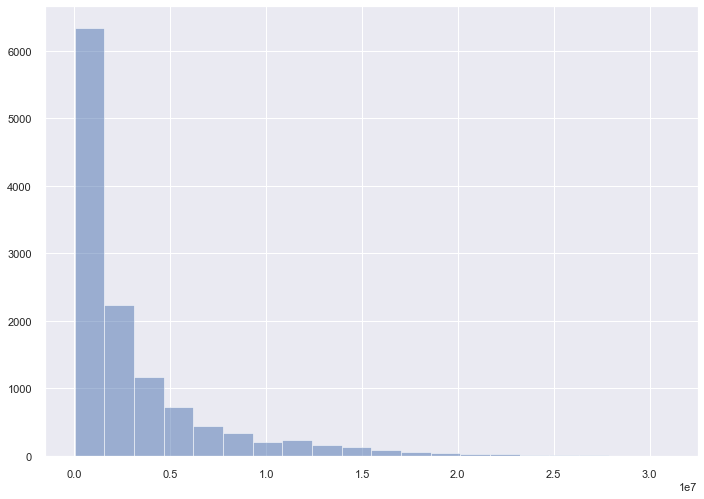

In [4286]:
df.salary.hist(bins=20, alpha=0.5)

In [4287]:
# categorical_salary_labels = ["One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine", "Ten"]
categorical_salary_labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
categorical_salary_bins = 10
df["categorical_salary"] = pd.qcut(df.salary, q=categorical_salary_bins, labels=categorical_salary_labels)

In [4288]:
df["categorical_salary"].unique()

[2, 3, 4, 6, 7, 8, 5, 9, 10, 1]
Categories (10, object): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

In [4289]:
df["categorical_salary"].describe()

count     12233
unique       10
top           4
freq       1242
Name: categorical_salary, dtype: object

Vergleich der Datenaufteilung in den einzelnen Bins.

In [4290]:
for label in categorical_salary_labels:
    print(df.loc[df["categorical_salary"] == label].size)

129675
128310
127365
130410
126630
129255
127575
128310
128415
128520


# === === === === === === === === === ===
# Train / Test Split

In [4291]:
split_df = df

## Trainingsdaten

In [4292]:
X = split_df.drop(columns = ["salary", "categorical_salary"])

### Top Ten Correlation Features

Die zuvor berechneten top 10 Correlation Features zu nehmen würde in einem schlechteren _Linear Regression Score_ resultieren.

In [4293]:
# X = X[top_10_correlations]

### Top 30 Linear Regression Score Features

Die später berechneten top 30 Linear Regression Features zu nehmen würde in einem schlechteren _Linear Regression Score_ resultieren.

In [4294]:
"""

top_30 = [
    'TRB', 'PTS', 'DRB', 'drafted_player_False', 'drafted_player_True',
    'FG', 'FGA', '2PA', 'attended_college_False',
    'attended_college_True', 'ORB', 'FT', '3PA',
    'attended_high_school_False', 'attended_high_school_True', '3P',
    '2P', 'position_PF', 'shoots_Right', 'shoots_Left', 'position_C',
    'position_PG', 'position_SF', 'position_SG', 'team_LAC',
    'team_CLE', 'team_PHO', 'team_IND', 'team_GSW', 'team_NYK'
]
X = X[top_30]

"""

"\n\ntop_30 = [\n    'TRB', 'PTS', 'DRB', 'drafted_player_False', 'drafted_player_True',\n    'FG', 'FGA', '2PA', 'attended_college_False',\n    'attended_college_True', 'ORB', 'FT', '3PA',\n    'attended_high_school_False', 'attended_high_school_True', '3P',\n    '2P', 'position_PF', 'shoots_Right', 'shoots_Left', 'position_C',\n    'position_PG', 'position_SF', 'position_SG', 'team_LAC',\n    'team_CLE', 'team_PHO', 'team_IND', 'team_GSW', 'team_NYK'\n]\nX = X[top_30]\n\n"

### Ausschließlich Saisonstatistiken 

Die ausschließliche Verwendung der Saisonstatistiken würde in einem schlechteren _Linear Regression Score_ resultieren.

In [4295]:
statistics = [
    "3P%",
    "FT%",                   
    "2P%",                      
    "FTr",                       
    "FG%",                     
    "eFG%",                  
    "3PAr",                   
    "TS%",                    
    "TOV%",                  
    "ORB%",                      
    "TRB%",                      
    "DRB%",                      
    "WS/48",                     
    "BLK%",                       
    "PER",                        
    "STL%",                     
    "USG%",                      
    "AST%",
    "MP",                         
    "GS",                         
    "G",                                                           
    "PTS",                        
    "PF",                         
    "OWS",                        
    "TOV",                        
    "BLK",                        
    "STL",                        
    "AST",                        
    "TRB",                        
    "DRB",                        
    "ORB",                        
    "FTA",                        
    "FT",                         
    "2PA",                        
    "2P",                         
    "3PA",                        
    "3P",                         
    "FGA",                        
    "FG",                         
    "VORP",                       
    "BPM",                        
    "DBPM",                       
    "OBPM",                       
    "WS",                         
    "DWS"
]

In [4296]:
# X = X[statistics]

### Verwerfen von Features

Das Verwerfen der folgenden Features führt zu leichten Verbesserungen des _Linear Regression Score_.

In [4297]:
X.drop(columns = ["season_start"], inplace=True)

In [4298]:
X.drop(columns = ["3P%"], inplace=True)

## Testdaten

Die Verwendung des __categorical_salary__ hat im Allgemeinen zu besseren Ergebnissen geführt.

In [4299]:
# y = split_df["salary"]

In [4300]:
y = split_df["categorical_salary"]

In [4301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4302]:
# X = ((X-X.min())/(X.max()-X.min()))

In [4303]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# === === === === === === === === === ===
# Linear Regression

In [4304]:
# With StandardScaler
X_train_linear = X_train_std
X_test_linear = X_test_std

# Without StandardScaler
# X_train_linear = X_train
# X_test_linear = X_test

y_train_linear = y_train
y_test_linear = y_test

## Anwendung

In [4305]:
linreg_model = LinearRegression().fit(X_train_linear, y_train_linear)
linreg_predictions = linreg_model.predict(X_test_linear)

for i, prediction in enumerate(linreg_predictions[:10]):
    print('real: {} -- pred: {}'.format(np.array(y_test_linear)[i], prediction))

real: 1 -- pred: 2.4596339093781925
real: 1 -- pred: 4.973801695022724
real: 7 -- pred: 5.777741514358661
real: 7 -- pred: 4.4003992902375675
real: 2 -- pred: 3.1089030133820987
real: 1 -- pred: -0.44956866630540127
real: 7 -- pred: 6.219376646194599
real: 1 -- pred: 0.8957072126008487
real: 3 -- pred: 4.773346983108661
real: 8 -- pred: 8.711808286819599


## Feature Analyse

### Korrelationen

In [4306]:
data = pd.DataFrame(abs(df.corr().salary).sort_values(ascending = False)).head(10)

In [4307]:
data.head(10)

salary
salary  1.000000
WS      0.426963
VORP    0.415971
PTS     0.414596
DRB     0.408879
FGA     0.400793
FG      0.400359
OWS     0.395474
FT      0.389620
FTA     0.385824

In [4308]:
data.tail(10)

salary
salary  1.000000
WS      0.426963
VORP    0.415971
PTS     0.414596
DRB     0.408879
FGA     0.400793
FG      0.400359
OWS     0.395474
FT      0.389620
FTA     0.385824

### Koeffizienten

In [4309]:
zipped = list(zip(X_train.columns, linreg_model.coef_))
data = pd.DataFrame(zipped, columns=['feature', 'coef'])
data = data.reindex(data.coef.abs().sort_values(ascending = False).index)

In [4310]:
data.head(10)

feature          coef
41                         TRB -5.672183e+11
47                         PTS  5.056530e+11
40                         DRB  4.011270e+11
49   attended_high_school_True -3.964289e+11
48  attended_high_school_False -3.964289e+11
50        drafted_player_False  3.807834e+11
51         drafted_player_True  3.807834e+11
54                shoots_Right  2.796965e+11
52                 shoots_Left  2.787829e+11
56                 position_PF -2.589522e+11

In [4311]:
data.tail(10)

feature      coef
15    STL% -0.096931
44     BLK  0.087158
5       GS  0.084230
14    AST% -0.077570
10     FTr -0.076174
34     2P%  0.044281
8      TS%  0.034171
16    BLK%  0.032287
38     FT% -0.031061
35    eFG%  0.025167

## Ergebnis

In [4312]:
def print_outcome_for_linear():
    score_result = linreg_model.score(X_test_linear, y_test_linear)
    print('coefficient of determination:', score_result, '\n')
    
    explained_variance_score_result = round(explained_variance_score(np.array(y_test_linear), linreg_predictions) * 100, 2)
    print('explained variance score in %:', explained_variance_score_result, '\n')
    
    mean_squared_error_result = mean_squared_error(np.array(y_test_linear), linreg_predictions)
    print('mean squared error:', mean_squared_error_result, '\n')

In [4313]:
print_outcome_for_linear()

coefficient of determination: 0.5863465860513397 

explained variance score in %: 58.64 

mean squared error: 3.3577137953073675 



# === === === === === === === === === ===
# Logistic Regression

In [4314]:
X_train_logistic = X_train_std
X_test_logistic = X_test_std

y_train_logistic = y_train
y_test_logistic = y_test

## Anwendung

In [4315]:
logreg_model = LogisticRegression(C=1.0, solver='lbfgs', multi_class='ovr', max_iter=1000).fit(X_train_logistic, y_train_logistic)

logreg_predictions = logreg_model.predict(X_test_logistic)

for i, prediction in enumerate(logreg_predictions[:10]):
    print('real: {} -- pred: {}'.format(np.array(y_test_logistic)[i], prediction))

real: 1 -- pred: 1
real: 1 -- pred: 1
real: 7 -- pred: 6
real: 7 -- pred: 4
real: 2 -- pred: 1
real: 1 -- pred: 1
real: 7 -- pred: 5
real: 1 -- pred: 1
real: 3 -- pred: 4
real: 8 -- pred: 9


## Ergebnis

In [4316]:
def print_outcome_for_logistic():
    score_result = logreg_model.score(X_test_logistic, y_test_logistic)
    print('coefficient of determination:', score_result, '\n')
    
    explained_variance_score_result = round(explained_variance_score(np.array(y_test_logistic), logreg_predictions) * 100, 2)
    print('explained variance score in %:', explained_variance_score_result, '\n')
    
    mean_squared_error_result = mean_squared_error(np.array(y_test_logistic), logreg_predictions)
    print('mean squared error:', mean_squared_error_result, '\n')

In [4317]:
print_outcome_for_logistic()

coefficient of determination: 0.2880852117909339 

explained variance score in %: 33.24 

mean squared error: 5.426058954669309 



# === === === === === === === === === ===
# KNN

In [4318]:
X_train_knn = X_train_std
X_test_knn = X_test_std

y_train_knn = y_train
y_test_knn = y_test

## Anwendung

Die besten Settings wurden mit dem __salary__ als SUT ermittelt. Die Durchlaufzeit verhindert ein Austesten von vielen verschiedenen Setups.

Durch die Verwendung von GridSearch (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ist _Cross Validation_ beispielsweise schon inkludiert.

In [4319]:
first = [50, 75, 100, 125, 150, 175, 200]
second = [100, 112, 125, 127, 150]
third = [100, 106, 112, 119, 125]
fourth = [111, 112, 113]
fifth = [112, 113, 114, 115]
sixth = [113]

In [4320]:
def do_grid_search_for_knn():
    param_grid = {
        'n_neighbors': sixth,
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance'],
    }
    
    clf = GridSearchCV(KNeighborsClassifier(), param_grid, verbose = 1, cv = 3, n_jobs = -1)
    return clf.fit(X_train_knn, y_train_knn)
    

In [4321]:
grid_knn = do_grid_search_for_knn()

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   10.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   11.0s finished


## Ergebnis

In [4322]:
def print_outcome_for_knn():
    print('best params:\n', grid_knn.best_params_, '\n')
    print('best score:\n', grid_knn.best_score_, '\n')
    print('best score (%):\n', round(grid_knn.best_score_ * 100, 2), '\n')

In [4323]:
print_outcome_for_knn()

best params:
 {'metric': 'manhattan', 'n_neighbors': 113, 'weights': 'distance'} 

best score:
 0.25195217179111756 

best score (%):
 25.2 



In [4324]:
# pd.DataFrame(grid_knn.cv_results_)

https://towardsdatascience.com/the-basics-knn-for-classification-and-regression-c1e8a6c955

> One other issue with a KNN model is that it lacks interpretability. An OLS linear regression will have clearly interpretable coefficients that can themselves give some indication of the ‘effect size’ of a given feature (although, some caution must taken when assigning causality). Asking which features have the largest effect doesn’t really make sense for a KNN model, however. Partly because of this, KNN models also can’t really be used for feature selection, in the way that a linear regression with an added cost function term, like ridge or lasso, can be, or the way that a decision tree implicitly chooses which features seem most valuable.

# === === === === === === === === === ===
# Decision Tree

In [4325]:
X_train_dt = X_train_std
X_test_dt = X_test_std

y_train_dt = y_train
y_test_dt = y_test

## Anwendung

Die besten Settings wurden mit dem __salary__ als SUT ermittelt. Die Durchlaufzeit verhindert ein Austesten von vielen verschiedenen Setups.

Durch die Verwendung von GridSearch (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ist _Cross Validation_ beispielsweise schon inkludiert.

In [4326]:
def do_grid_search_for_dt():
    param_grid = {
        # 'max_depth': range(1,30),
        # 'criterion': ["entropy", "gini"]
        'max_depth': [7], # Best Settings
        'criterion': ["entropy"] # Best Settings
    }

    clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, verbose=False, cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True) ,n_jobs = -1)
    return clf.fit(X_train_dt, y_train_dt) 

In [4327]:
grid_dt = do_grid_search_for_dt()

## Ergebnis

In [4328]:
def print_outcome_for_dt():
    print('best params:\n', grid_dt.best_params_, '\n')
    print('best score:\n', grid_dt.best_score_, '\n')
    print('best score (%):\n', round(grid_dt.best_score_ * 100, 2), '\n')
    print('best estimator:\n', grid_dt.best_estimator_, '\n')

In [4329]:
print_outcome_for_dt()

best params:
 {'criterion': 'entropy', 'max_depth': 7} 

best score:
 0.28135517919971387 

best score (%):
 28.14 

best estimator:
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 



### Darstellung

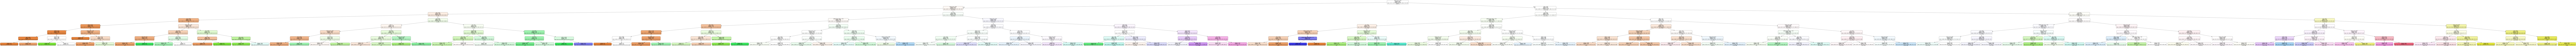

In [4330]:
column_names = X_train.columns

dot_data = StringIO()  

export_graphviz(grid_dt.best_estimator_, out_file=dot_data,  
                feature_names=column_names,
                filled=True, rounded=True,
                proportion=True,
                special_characters=True)  

(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

# === === === === === === === === === ===
# Neural Network

In [4331]:
X_train_nn = X_train_std
X_test_nn = X_test_std

y_train_nn = y_train
y_test_nn = y_test

## Anwendung

Die besten Settings wurden mit dem __salary__ als SUT ermittelt. Die Durchlaufzeit verhindert ein Austesten von vielen verschiedenen Setups.

Durch die Verwendung von GridSearch (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ist _Cross Validation_ beispielsweise schon inkludiert.

In [4332]:
first = [
    (1,),  (8,), (16,), (32,), (64,), (128,), (256,), (512,),
    (1, 1),  (8, 8), (16, 16), (32, 32), (64, 64), (128, 128), (256, 256), (512, 512),
    (1, 1, 1),  (8, 8, 8), (16, 16, 16), (32, 32, 32), (64, 64, 64), (128, 128, 128), (256, 256, 256), (512, 512, 512),
]

In [4333]:
def do_grid_search_for_nn():
    param_grid = {
        # 'hidden_layer_sizes': first,
        # 'activation': ['tanh', 'relu', 'logistic', 'identity']
        "hidden_layer_sizes": [(32, 32)], # Best Settings
        'activation': ['logistic']
    }
    
    mlp = MLPClassifier(max_iter=200)
    clf = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy')
    return clf.fit(X_train_nn, y_train_nn)

In [4334]:
grid_nn = do_grid_search_for_nn()

/Users/lukmac/.local/share/virtualenvs/data-mining-nba-jhiA2YFt/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/lukmac/.local/share/virtualenvs/data-mining-nba-jhiA2YFt/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/lukmac/.local/share/virtualenvs/data-mining-nba-jhiA2YFt/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/lukmac/.local/share/virtualenvs/data-mining-nba-jhiA2YFt/lib/python3.7/site-packages

## Ergebnis

In [4335]:
def print_outcome_for_nn():
    print('best params:\n', grid_nn.best_params_, "\n")
    
    print('best score:\n', round(grid_nn.best_score_ * 100, 2), "\n")
    
    predictions = grid_nn.predict(X_test_nn);
    print('predictions:\n', grid_nn.predict(X_test_nn), "\n")
    
    print('confusion matrix:\n', confusion_matrix(y_test_nn, predictions), "\n")
    print('classification report:\n', classification_report(y_test_nn, predictions), "\n")

In [4336]:
print_outcome_for_nn()

best params:
 {'activation': 'logistic', 'hidden_layer_sizes': (32, 32)} 

best score:
 30.59 

predictions:
 ['1' '1' '6' ... '6' '5' '2'] 

confusion matrix:
 [[233   0  65  46  25  14   5   5   6   6]
 [  6 261   1   0   5   7   6   3  16  76]
 [113   2 107  74  50  19  12   4   4   4]
 [ 40   0  89  92  65  35  48  13  10   9]
 [ 28   4  50  70  74  49  50  27  26  18]
 [ 19   2  32  69  73  86  51  27  28  31]
 [  7   6  19  42  68  65  91  53  28  19]
 [ 10  16  13  19  41  48  86  73  59  71]
 [ 13  34   3   7  27  29  46  54  92 104]
 [  6 107   1   2  12  22  16  22  66 150]] 

classification report:
               precision    recall  f1-score   support

           1       0.49      0.58      0.53       405
          10       0.60      0.69      0.64       381
           2       0.28      0.28      0.28       389
           3       0.22      0.23      0.22       401
           4       0.17      0.19      0.18       396
           5       0.23      0.21      0.22       418
   

# === === === === === === === === === ===
# PCA

In [4337]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

print(X.shape)
print(x_pca.shape)

(12233, 101)
(12233, 2)


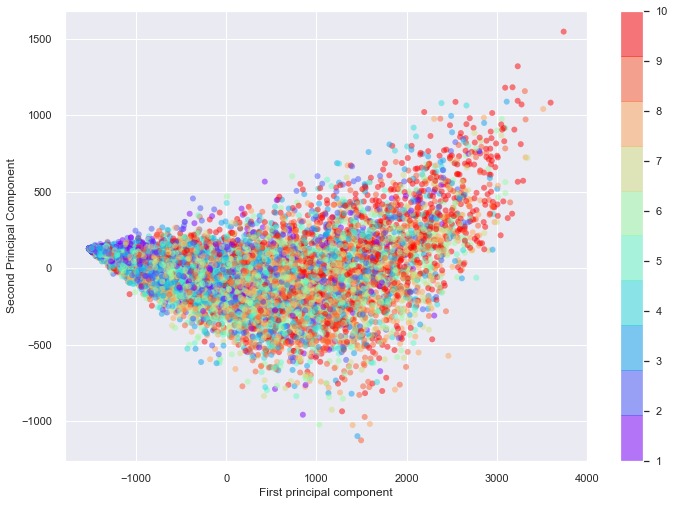

In [4338]:
y = y.astype(int) # Für categorical_salary
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y[:], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', 10))
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.colorbar()

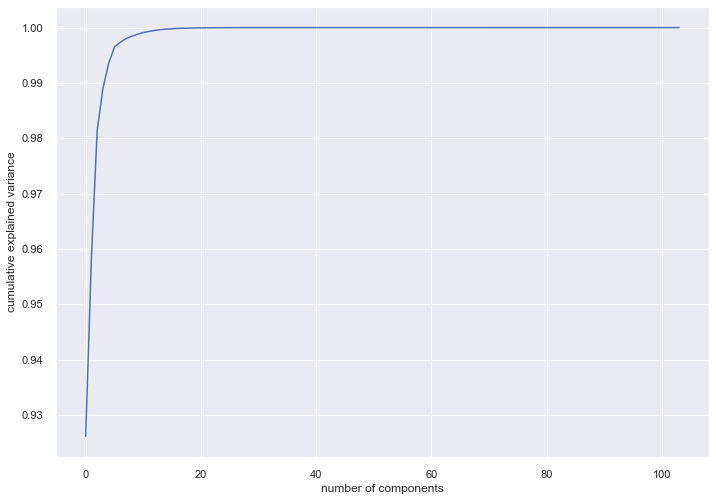

In [4339]:
pca = PCA().fit(split_df.drop(columns=['salary'])) # Für categorical_salary
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

https://medium.com/analytics-vidhya/principal-component-analysis-pca-with-code-on-mnist-dataset-da7de0d07c22

> PCA is mainly used for dimensionality reduction, not for visualization. To visualize high dimension data, we mostly use T-SNE.

# === === === === === === === === === ===
# T-SNE

In [4340]:
def do_tsne(n_iter, perplexity = 25):
    time_start = time.time()
    tsne = TSNE(n_iter=n_iter, perplexity=perplexity)
    tsne_results = tsne.fit_transform(X)
    
    print('time in seconds:', time.time() - time_start, '\n')
    print('time in minutes:', (time.time() - time_start) / 60, '\n')
    print("iterations:", tsne.n_iter_, '\n')
    print("perplexity: ", perplexity, '\n')
    print("Kullback-Leibler divergance:", tsne.kl_divergence_, '\n')
    
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', 10))

 ========== 250 ITERATIONS - FIRST ========== 

time in seconds: 16.580740928649902 

time in minutes: 0.27634944915771487 

iterations: 250 

perplexity:  25 

Kullback-Leibler divergance: 1.7976931348623157e+308 



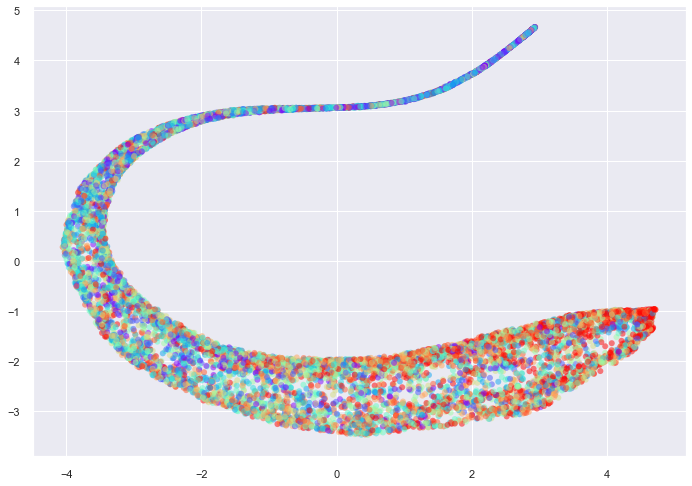

In [4341]:
print(" ========== 250 ITERATIONS - FIRST ========== \n")
do_tsne(250)

 ========== 250 ITERATIONS - SECOND ========== 

time in seconds: 17.778114795684814 

time in minutes: 0.2963052153587341 

iterations: 250 

perplexity:  25 

Kullback-Leibler divergance: 1.7976931348623157e+308 



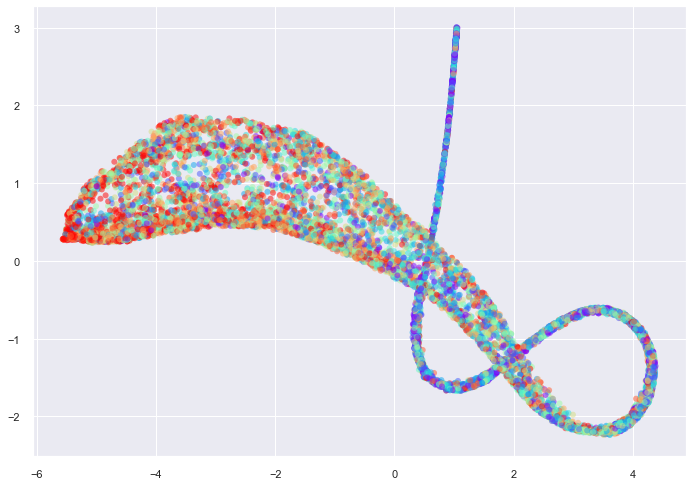

In [4342]:
print(" ========== 250 ITERATIONS - SECOND ========== \n")
do_tsne(250)

 ========== 500 ITERATIONS - FIRST ========== 

time in seconds: 30.496843814849854 

time in minutes: 0.5082851648330688 

iterations: 499 

perplexity:  25 

Kullback-Leibler divergance: 1.971196174621582 



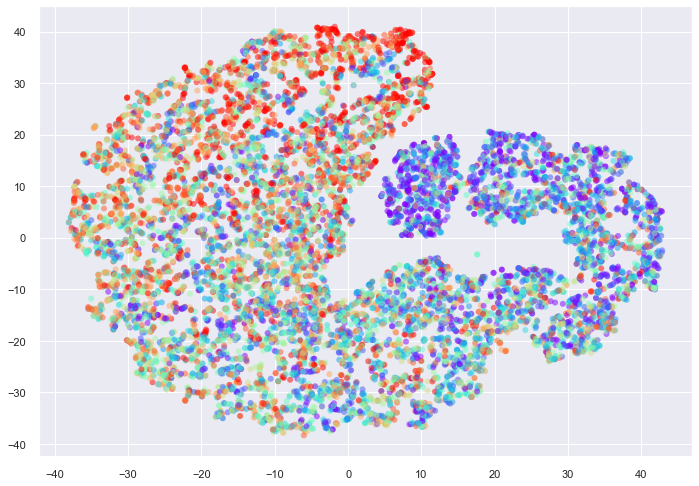

In [4343]:
print(" ========== 500 ITERATIONS - FIRST ========== \n")
do_tsne(500)

 ========== 500 ITERATIONS - SECOND ========== 

time in seconds: 29.87729001045227 

time in minutes: 0.49796226421991985 

iterations: 499 

perplexity:  25 

Kullback-Leibler divergance: 1.9759650230407715 



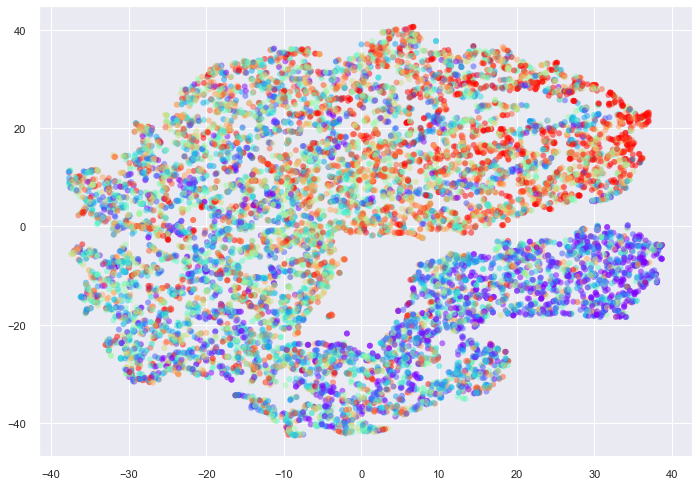

In [4344]:
print(" ========== 500 ITERATIONS - SECOND ========== \n")
do_tsne(500)

 ========== 1000 ITERATIONS - FIRST ========== 

time in seconds: 56.24126386642456 

time in minutes: 0.9373578468958537 

iterations: 999 

perplexity:  25 

Kullback-Leibler divergance: 1.6109038591384888 



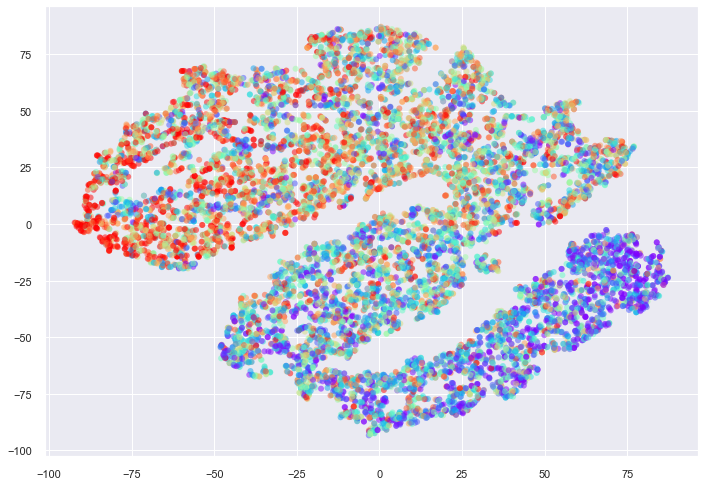

In [4345]:
print(" ========== 1000 ITERATIONS - FIRST ========== \n")
do_tsne(1000)

 ========== 1000 ITERATIONS - SECOND ========== 

time in seconds: 57.90593981742859 

time in minutes: 0.9651079177856445 

iterations: 999 

perplexity:  25 

Kullback-Leibler divergance: 1.6131049394607544 



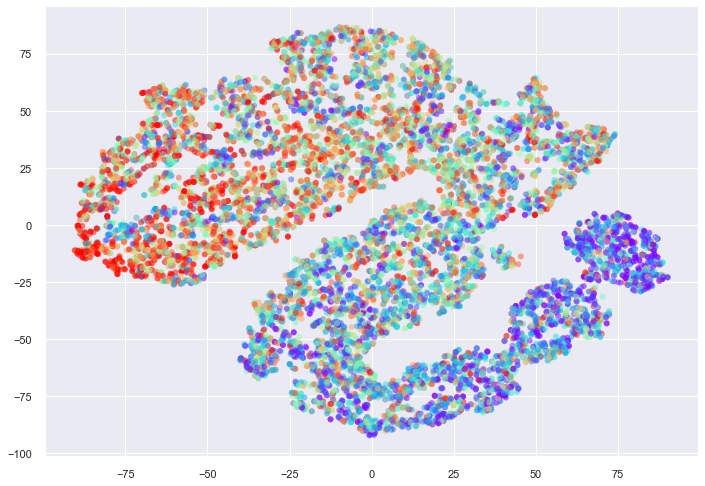

In [4346]:
print(" ========== 1000 ITERATIONS - SECOND ========== \n")
do_tsne(1000)

 ========== 20000 ITERATIONS - FIRST ========== 

time in seconds: 118.46839189529419 

time in minutes: 1.974476965268453 

iterations: 1999 

perplexity:  25 

Kullback-Leibler divergance: 1.516768217086792 



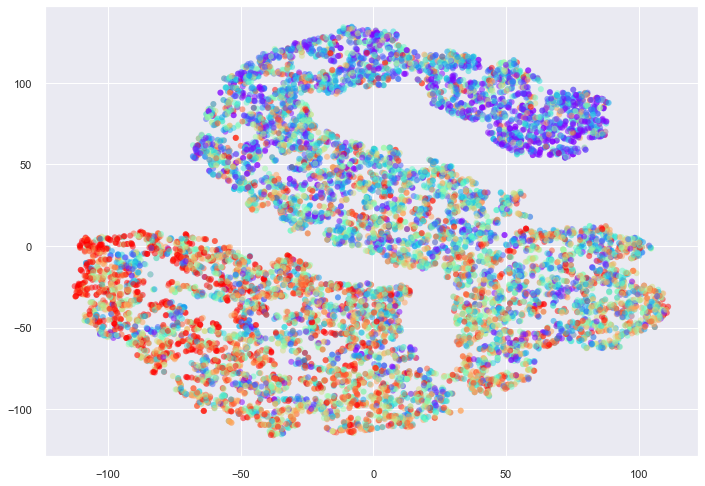

In [4347]:
print(" ========== 20000 ITERATIONS - FIRST ========== \n")
do_tsne(2000)

 ========== 20000 ITERATIONS - SECOND ========== 

time in seconds: 120.32301473617554 

time in minutes: 2.005387246608734 

iterations: 1999 

perplexity:  25 

Kullback-Leibler divergance: 1.5040699243545532 



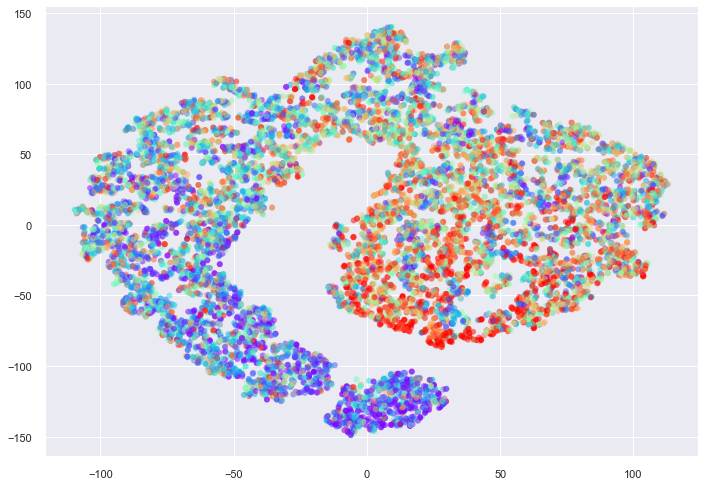

In [4348]:
print(" ========== 20000 ITERATIONS - SECOND ========== \n")
do_tsne(2000)

# === === === === === === === === === ===
# KMeans

In [4349]:
def do_kmeans(n_clusters):
    data_df = pd.DataFrame(X_pca, columns=['first_pc', 'second_pc'])
    
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_df)
    
    y_kmeans = kmeans.predict(data_df)
    
    plt.scatter(data_df.first_pc, data_df.second_pc, c=y_kmeans, s=50, cmap='viridis')
    plt.show()

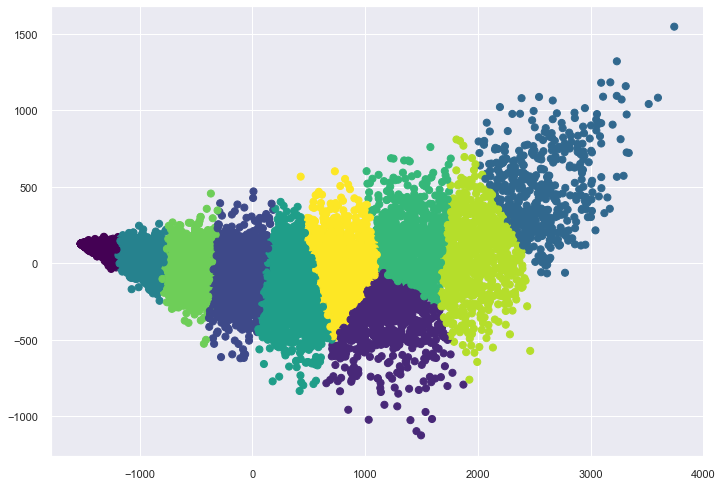

In [4350]:
do_kmeans(categorical_salary_bins)

# === === === === === === === === === ===
# Spectral Clustering

In [4351]:
def do_spectral_clustering(n_clusters):
    data_df = pd.DataFrame(X_pca, columns=['first_pc', 'second_pc'])
    
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
    y_spectral_clustering = spectral_clustering.fit(data_df)
        
    plt.scatter(data_df.first_pc, data_df.second_pc, c=y_spectral_clustering.labels_, s=50, cmap='viridis')
    plt.show()

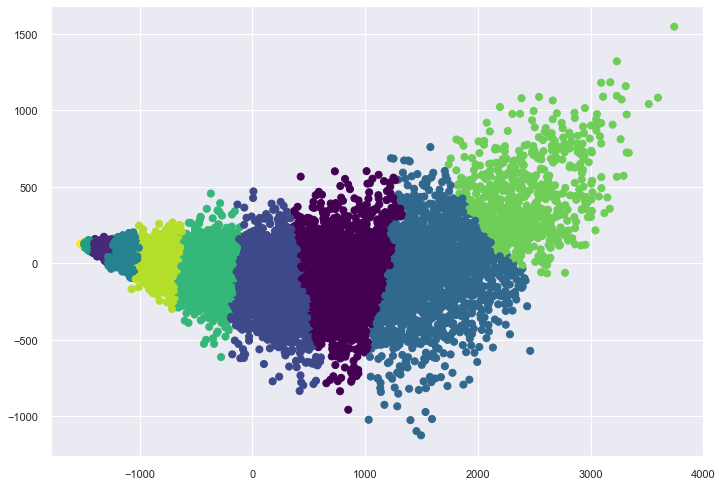

In [4352]:
do_spectral_clustering(categorical_salary_bins)

# === === === === === === === === === ===
# Ergebnis

| SUT                | Linear | Logistic | KNN  | Decision Tree | Neural Network |
|--------------------|--------|----------|------|---------------|----------------|
| slaray             | 51.46  | 28.67    | 2.46 | 6.81          | 2.88           |
| categorical salary | 58.64  | 33.24    | 25.2 |  28.09        | 31.03          |


Die erzielten Ergebnisse, vor allem jene die __salary__ als _subject under test (SUT)_ haben, sind leider sehr enttäuschend. Aufgrund der zahlreichen zur Verfügung gestellten Features hätte man sich ein beseres Ergebnis erwartet.

Durch die Einteilung in _bins_ - also __categorical salary__ - sind die Ergebnisse etwas besser geworden. Wenn man die Bin-Anzahl verringert kann das Ergebnis logischerweise noch etwas verbessert werden. Möglicherweise wäre eine Einteilung in drei bzw. vier Stufen (wenig, mittel, hoch, (top)) auch denkbar.